# Flight Price Prediction #

## Introduction ##

Traveling by air is a common practice for many people around the globe, and the cost of air travel is a major factor in travel planning. For a given route, airfares can fluctuate significantly over time due to a variety of factors, such as demand, seasonality, and airline pricing strategies. This can lead to a common predicament for travelers: should they purchase their tickets now, or wait in the hopes of a price drop?

The aim of this project is to build a machine learning model that can help resolve this predicament. The model will predict whether it is optimal to purchase the ticket now or wait for a potential price drop.

The dataset used in this notebook is provided by Prof. Dr. Martin Spott and Manu Mutthatu.
It contains flight data from 2019 for the following routes:
-   London Stansted and Berlin Schönefeld
-   London Stansted and Frankfurt

This task is a practical application of machine learning that can provide valuable insights for both travelers and businesses in the travel industry. By predicting the optimal time to purchase a flight ticket, one can potentially save money and make travel planning less stressful. For businesses, this model can be used to build a buisness plan, to recommend the best time to purchase tickets to customers, or to optimize pricing strategies.

The journey will now commence into the realm of data analysis, followed by the development of the predictive model.

In [391]:
# TODO: Beschreiben, ob target variable price oder buy ist --> anpassen

## Load the data ##

In this section, we will load the necessary Python libraries and the dataset we will be working with. This dataset, stored in a CSV file, is seperated in a train and a test dataset, each containing information about flight price requests. The test dataset is used to finally evaluate the performance of the model we will train on the train dataset. So in this notebook we will mostly use the train dataset and only use the test dataset to create a final prediction based on the trained model to see how well it performs compared to models trained by others.

In [392]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import sklearn
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve


pd.options.mode.chained_assignment = None  # default='warn'

In [393]:
# read in the data
df_train = pd.read_csv('train_set.csv')
df_test = pd.read_csv('test_set.csv')

## Data Exploration and Feature Engineering ##

**Data Exploration** <br>
is the first step in this workflow we delve into the dataset to understand the relationships and trends between different features. This phase is crucial as it provides insights into the data, which can guide our model training later. We will perform several tasks, including:

- Reviewing the first rows of the dataset for a general overview
- Investigating the data types of each feature to comprehend the nature of data we are dealing with
- Checking for duplicate and missing values and considering strategies to handle them
- Computing basic statistical metrics (mean, standard deviation, quartiles) to understand the distribution of data
- Dig deeper into the data by plotting histograms and other charts for each feature to provide visual insights
- Investigating the correlations among features. This will help us understand if some features are redundant due to high correlations with other features or if some features are highly correlated with the target variable and can be used to predict it


**Feature Engineering** <br> 
 involves creating new features from the existing data to improve the predictive power of the model. This might involve transforming, combining, deriving, or otherwise manipulating data to better utilize the information they hold. 
 For instance, it might be useful to extract the day of the week from the flight date, as weekend flights might be pricier than weekday flights. 
 Additionally, a strategy to handle categorical features is required, as most machine learning algorithms can only handle numerical data.


### Get to know the data ###

In [394]:
# make a copy of the data
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

# check the data
df_train_copy.head()

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,min_future_price_in_Eur,buy
0,1,2019-06-03T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,208.07,259.07,1
1,2,2019-06-03T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
2,3,2019-06-04T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
3,4,2019-06-04T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
4,5,2019-06-03T11:00:00Z,2019-06-05,21,2019-06-05 FR 147,STN-SXF,143.86,251.72,1


The data contains the following columns:
-   *index*: index of the row
-   *request_date*: date when the request was made
-   *flight_date*: date when the flight took place
-   *departure_hour*: hour when the flight departed
-   *flight_unique_id*: unique id for each flight
-   *route_abb*: abbreviation of the route
-   *price_in_eur*: price of the flight in euro
-   *min_future_price_in_euro*: minimum price of the flight in euro for all future request dates
-   *buy*: 1 if the flight should now be bought, 0 if one should wait

In [395]:
# check the number of rows and columns
df_train_copy.shape

(83624, 9)

The data contains 83624 rows and 9 columns.

In [396]:
# check the data types
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83624 entries, 0 to 83623
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    83624 non-null  int64  
 1   Request_Date             83624 non-null  object 
 2   Flight_Date              83624 non-null  object 
 3   Departure_hour           83624 non-null  int64  
 4   flight_unique_id         83624 non-null  object 
 5   route_abb                83624 non-null  object 
 6   Price_In_Eur             83624 non-null  float64
 7   min_future_price_in_Eur  83624 non-null  float64
 8   buy                      83624 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 5.7+ MB


The data types are correct, except for the date columns. We will deal with that later.

In [397]:
# check if there are any missing values
df_train_copy.isnull().sum()

index                      0
Request_Date               0
Flight_Date                0
Departure_hour             0
flight_unique_id           0
route_abb                  0
Price_In_Eur               0
min_future_price_in_Eur    0
buy                        0
dtype: int64

Luckily, there are no missing values in the data.

In [398]:
# check for duplicates
df_train_copy.duplicated().sum()

0

There are no duplicates in the data.

Next, we will search for outliers in the data. Therefore we look at the z-score of each value in the data. The z-score is the number of standard deviations away from the mean a data point is. We will remove all data points that have a z-score bigger them 3, because these are considered as outliers, because the standard deviation differ too much from the mean.

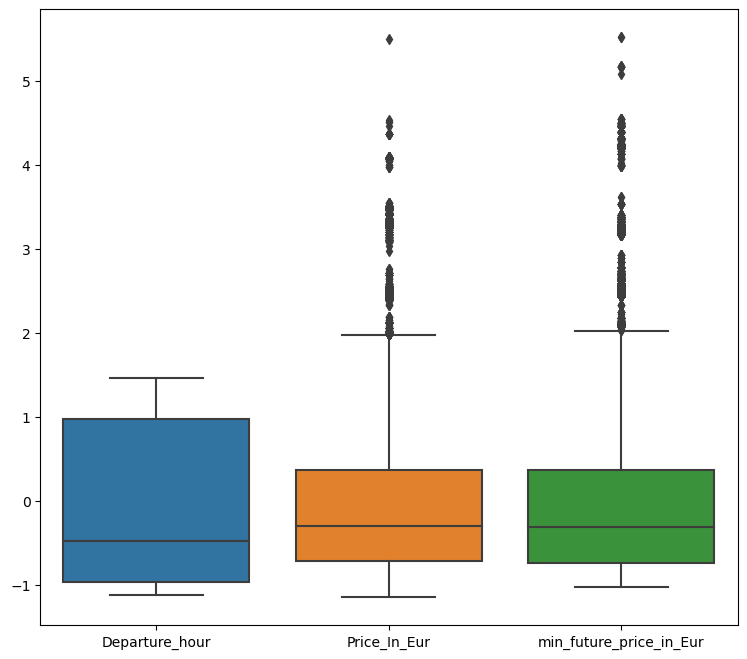

In [399]:
## Get the z-scores and create boxplots for the numerical columns

# Calculate z-scores for the numerical columns
df_train_num = df_train_copy[['Departure_hour', 'Price_In_Eur', 'min_future_price_in_Eur']]
z_scores_train = stats.zscore(df_train_num)

# Calculate z-scores for the numerical columns
z_scores_test = stats.zscore(df_train_num[['Departure_hour', 'Price_In_Eur', 'min_future_price_in_Eur']])

# Create Boxplots for the z-scores
plt.figure(figsize=(9, 8))
sns.boxplot(data=z_scores_train);

In [400]:
## Get the data considered as outliers

# Get the rows with z-scores > 3
outliers_train = np.where(z_scores_train > 3)

# Get the rows in the df_train_copy that contain outliers
df_train_copy_outlier_rows = df_train_copy.iloc[outliers_train[0]]

# Check the proportion of outliers
print(len(df_train_copy_outlier_rows)/len(df_train_copy))

0.04889744570936573


There are around 4.9% outliers in the data. Before we remove or transform them, we need to check if the outliers are reasonable or not. If they are reasonable, we can keep them. If they are not reasonable, we can remove them or transform them. Therefore we look at some features and their relationship with the outliers.

In [401]:
# Check the distribution of the route_abb column for the outliers
df_train_copy_outlier_rows['route_abb'].value_counts()

STN-SXF    1899
SXF-STN    1479
STN-FRA     393
FRA-STN     318
Name: route_abb, dtype: int64

In [402]:
# Check the distribution of Departure_hour column for the outliers
df_train_copy_outlier_rows['Departure_hour'].value_counts()

19    1247
6      767
18     667
7      666
10     349
22     285
8       68
21      40
Name: Departure_hour, dtype: int64

It seems that the outliers are not random but are associated with specific routes and departure hours. This suggests that they might be extreme but valid data points. Therefore we will not remove or replace them.

In [403]:
# check the noise in the data
df_train_copy.describe()

,index,Departure_hour,Price_In_Eur,min_future_price_in_Eur,buy
count,83624.000000,83624.000000,83624.000000,83624.000000,83624.000000
mean,41812.500000,12.969889,71.965080,56.593014,0.223835
std,24140.313792,6.177936,54.788483,46.126909,0.416815
min,1.000000,6.000000,8.990000,8.990000,0.000000
25%,20906.750000,7.000000,32.770000,22.270000,0.000000
50%,41812.500000,10.000000,55.080000,41.890000,0.000000
75%,62718.250000,19.000000,91.790000,73.430000,0.000000
max,83624.000000,22.000000,372.960000,311.090000,1.000000


-  Departure_hour: earliest departure hour is 6 (6 am), latest departure hour is 22 (10pm). Mean is 13 (1 pm).
-  Price_In_Eur: minimum price is 8.99€, maximum price is 372.96€. Average price is 72€.
-  Min_future_price_in_euro: minimum minimum future price is 8.99€, maximum minimum future price is 311.09€. Average minimum future price is 57€.
-  Buy: is a boolean value. Therefore the description is not very meaningful except we can see, that more flights in the data were recommended to wait than to buy.

Now we want to dig deeper into the data and see if we can find any interesting insights that we can use to improve our model. Therefore we will have a look at each feature. Those include:   
- Price_In_Eur               
- min_future_price_in_Eur  
- Request_Date               
- Flight_Date                
- Departure_hour             
- route_abb                 
- buy                  
- flight_unique_id                 

### Price in Eur ###

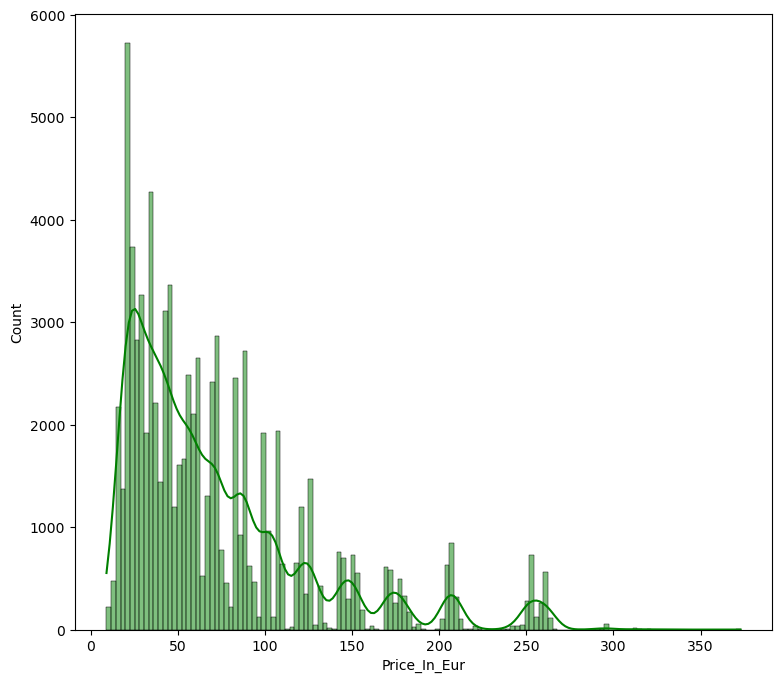

In [404]:
# check the distribution of Price in Euro
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Price_In_Eur'], color='g', kde=True);

The prices seem to be quite evenly distributed. There are fluctuations in the higher prices that seem to be repeated. Also there seems to be some more expensive flights in prices around and above 350€.

### Min Future Price in Euro ###

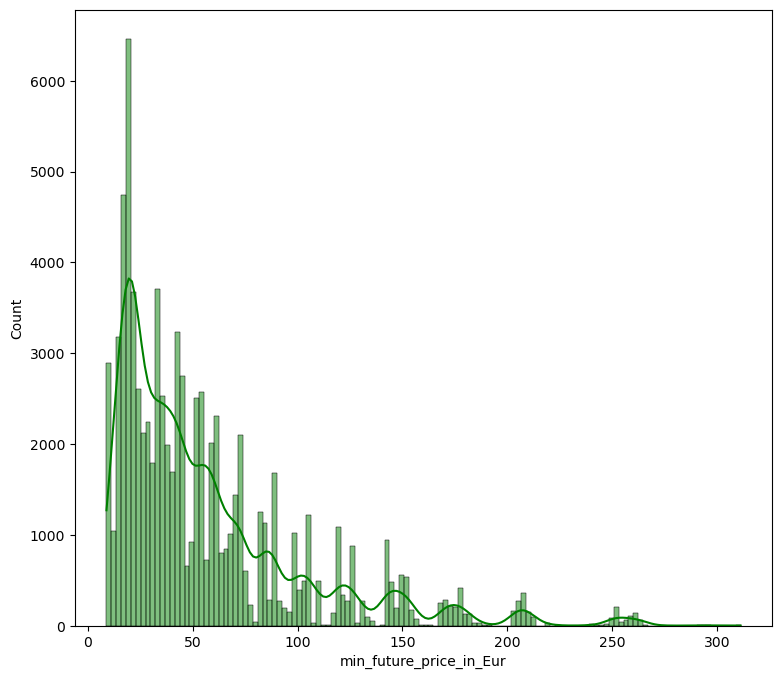

In [405]:
# check distribution of min_future_price_in_eur
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['min_future_price_in_Eur'], color='g', kde=True);

The min_future_price_in_Eur distribution nearly looks exactly like the Price_in_Eur distribution. This is as expected, since the min_future_price_in_Eur is the minimum price (Price__in_Eur) of the flight in the future. 

### Request Date ###

Request_Date is of type object. Therefore we need to convert it to datetime format so that we can extract information like day or month from it.

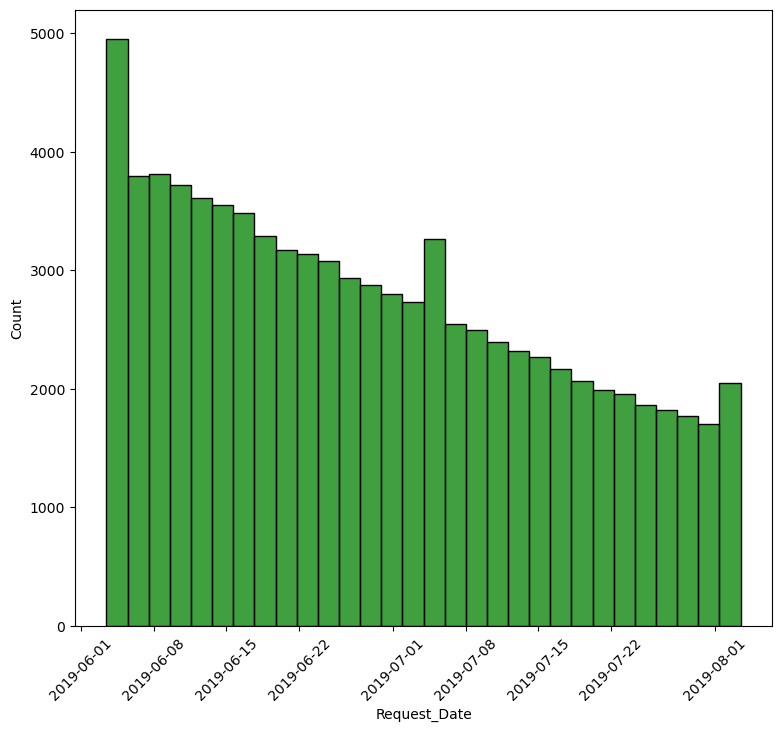

In [406]:
# check the distribution of the request date
# convert the request date to datetime
df_train_copy['Request_Date'] = pd.to_datetime(df_train_copy['Request_Date'])

plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Request_Date'], color='g', bins=30);

# rotate the x axis value description to make it more readable
plt.xticks(rotation=45);


In [407]:
# check the last date in the data
print(df_train_copy['Request_Date'].min())
print(df_train_copy['Request_Date'].max())

2019-06-03 11:00:00+00:00
2019-08-03 11:00:00+00:00


The data contains requests from 2019-06-03 to 2019-08-03.

Maybe it is useful for the model to know in which month the flight is taking place. So we will add a new column called "Request_Month" to the dataframe.

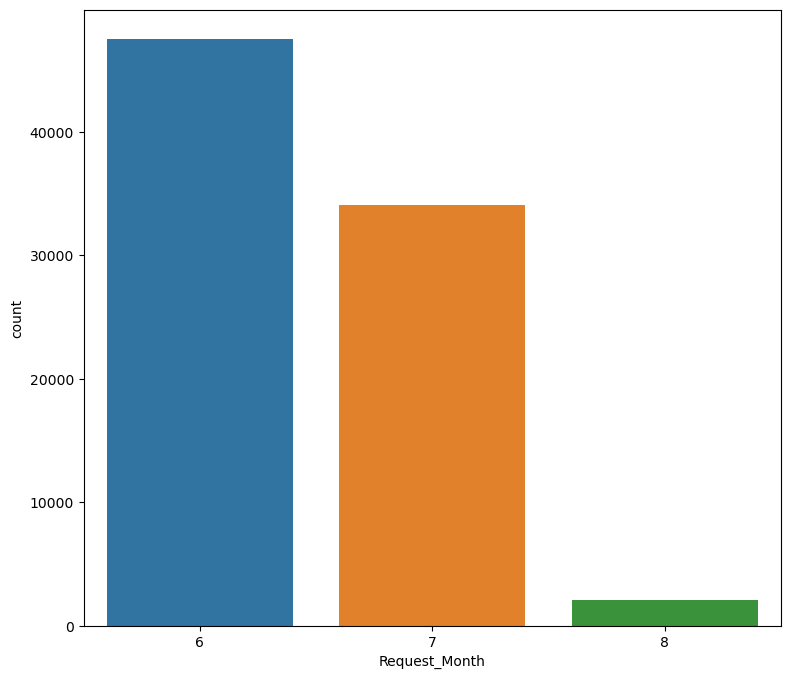

In [408]:
# Extract the month from the request date
df_train_copy['Request_Month'] = df_train_copy['Request_Date'].dt.month

# plot the request month
plt.figure(figsize=(9, 8))
sns.countplot(x='Request_Month', data=df_train_copy);

The data only contains requests of the months 6, 7 and 8, meaning June, July and August. The Month with the most requests is June, a little less in July and only a few in August.

Additionally it may be interesting to know, on which day of the week the request was made. This can be done by extracting the day of the week from the date of the request. The day of the week is encoded as a number between 0 and 6, where 0 is Monday and 6 is Sunday.

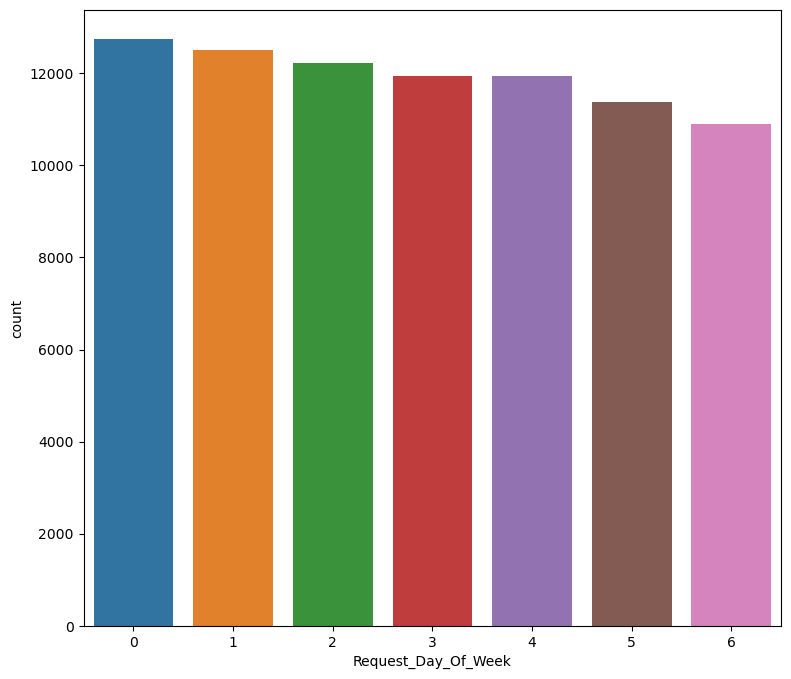

In [409]:
# Extract the day of the week from the request date
df_train_copy['Request_Day_Of_Week'] = df_train_copy['Request_Date'].dt.dayofweek
# 0 = Monday, 6 = Sunday

# plot the request day of the week
plt.figure(figsize=(9, 8))
sns.countplot(x='Request_Day_Of_Week', data=df_train_copy);

There are nearly the same amount of requests on each day of the week.

Maybe it is interesting to know if the request was made on a weekend or not. So we will create a new feature called "Request_is_Weekend" which will be 1 if the request was made on a weekend and 0 if it was made on a weekday.

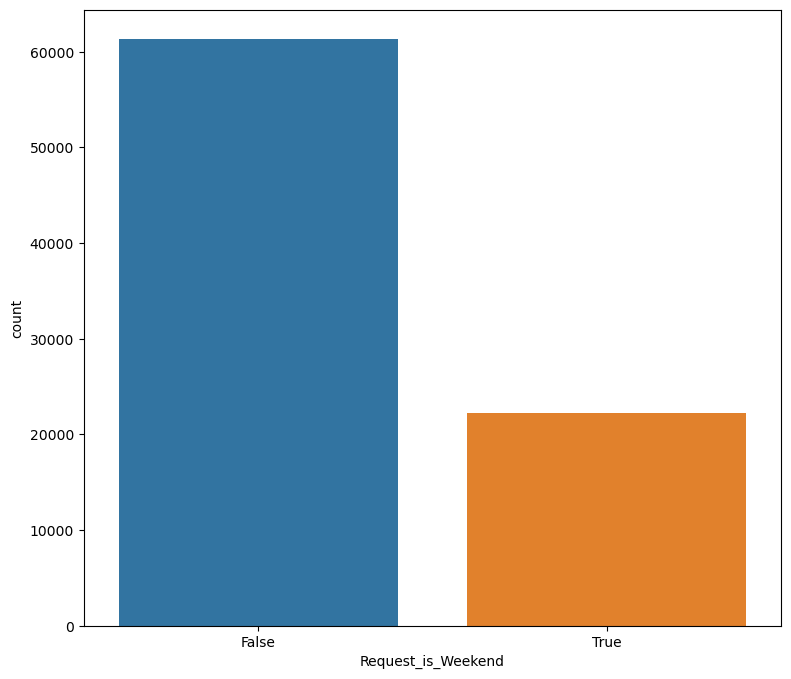

In [410]:
# create a new column to indicate if the request was made on a weekend
df_train_copy['Request_is_Weekend'] = df_train_copy['Request_Date'].dt.weekday >= 5

# plot the request is weekend
plt.figure(figsize=(9, 8))
sns.countplot(x='Request_is_Weekend', data=df_train_copy);

In [411]:
#  TODO: gehört in Korrelationsanalyse
# plot Request_is_Weekend with buy
# plt.figure(figsize=(9, 8))
# sns.countplot(x='Request_is_Weekend', hue='buy', data=df_train_copy);

The Request_Date contains information regarding the time in which the request was made. With this information, we can create a new feature called "Request_Hour" which will contain the hour of the day in which the request was made.

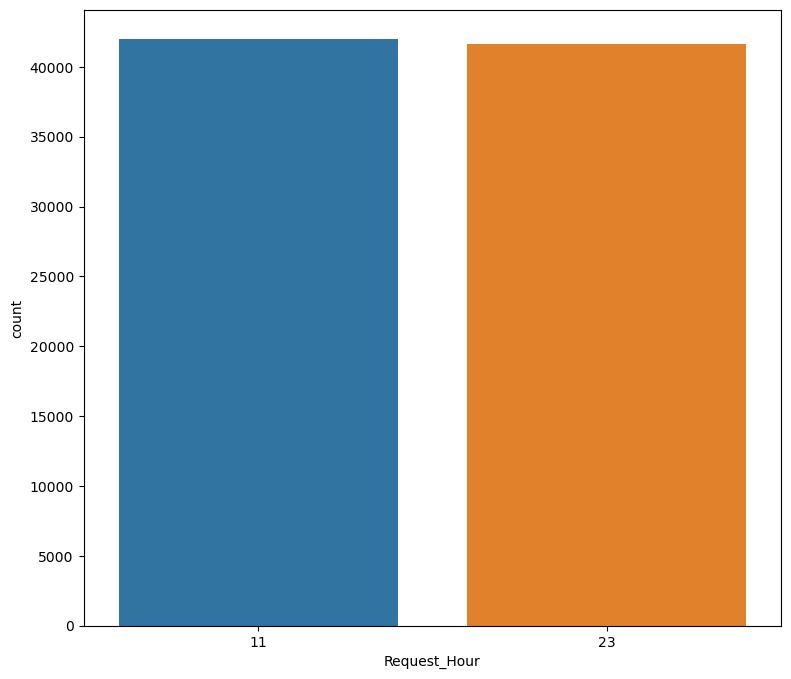

In [412]:
# extract the hour from the request date
df_train_copy['Request_Hour'] = df_train_copy['Request_Date'].dt.hour

# plot the request hour
plt.figure(figsize=(9, 8))
sns.countplot(x='Request_Hour', data=df_train_copy);

There were requests only at 11 (11 am) and at 23 (11 pm).

### Flight Date ###

Just like the Request_Date column the Flight_Date column is also from type object. We need to convert it to datetime format.

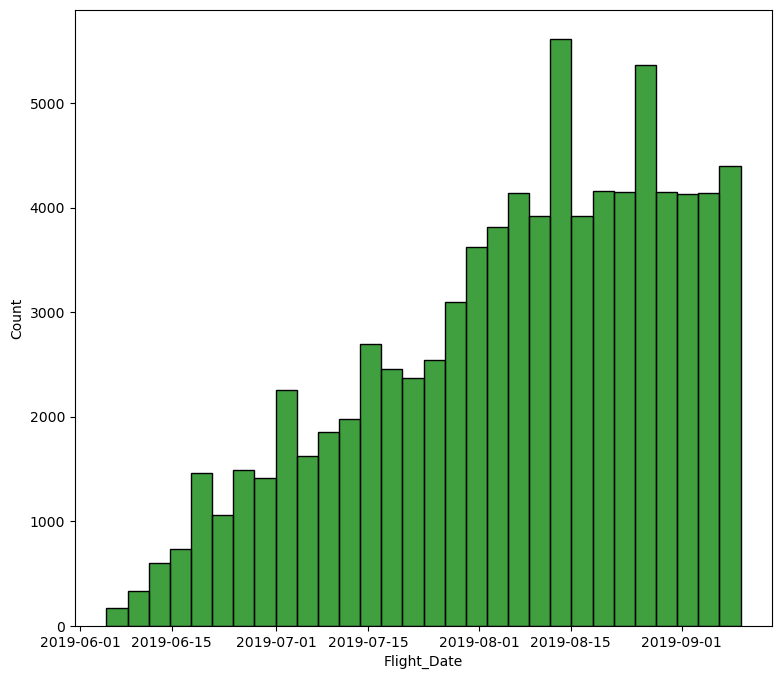

In [413]:
# check the distribution of flight date
# convert the flight date to datetime
df_train_copy['Flight_Date'] = pd.to_datetime(df_train_copy['Flight_Date'])

plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Flight_Date'], color='g', bins=30);

In [414]:
# get the first and the last flight date
print(df_train_copy['Flight_Date'].min())
print(df_train_copy['Flight_Date'].max())

2019-06-05 00:00:00
2019-09-10 00:00:00


The first flight left on 2019-06-05 and the last flight on 2019-09-10.

Again, we extract the informa

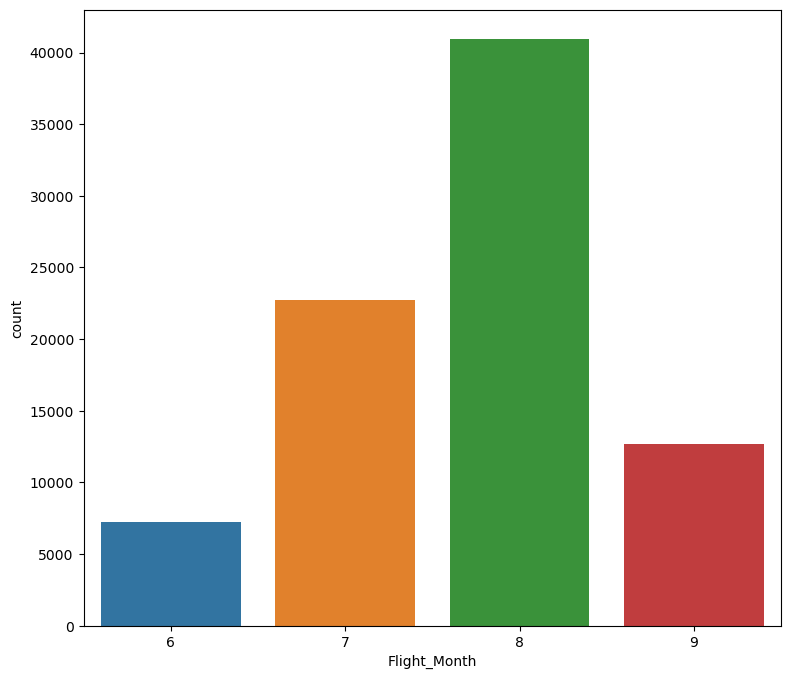

In [415]:
# Extract the month from the flight date
df_train_copy['Flight_Month'] = df_train_copy['Flight_Date'].dt.month

# plot the flight month
plt.figure(figsize=(9, 8))
sns.countplot(x='Flight_Month', data=df_train_copy);

Most flights depart in August, around half as many in July and only a few in September and even less in June.

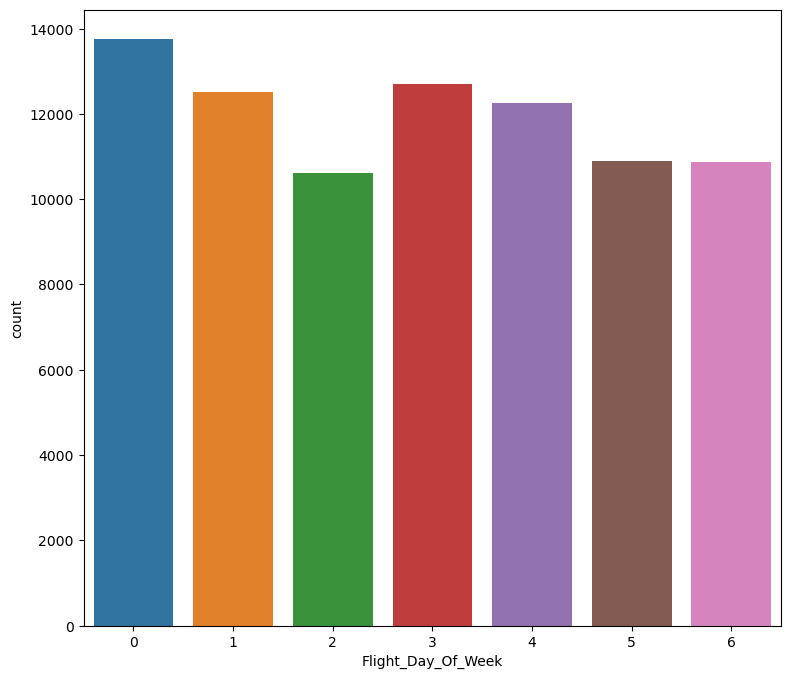

In [416]:
# Extract the day of the week from the flight date
df_train_copy['Flight_Day_Of_Week'] = df_train_copy['Flight_Date'].dt.dayofweek
# 0 = Monday, 6 = Sunday

# plot the flight day of the week
plt.figure(figsize=(9, 8))
sns.countplot(x='Flight_Day_Of_Week', data=df_train_copy);

In [417]:
# check data types of flight date and request date
print(df_train_copy['Flight_Date'].dtype)
print(df_train_copy['Request_Date'].dtype)

# remove the timezone from the request date
df_train_copy['Request_Date'] = df_train_copy['Request_Date'].dt.tz_convert(None)

# check dates, where the flight date is before the request date
flight_date_before_request_date = df_train_copy[df_train_copy['Flight_Date'] < df_train_copy['Request_Date']]

print(flight_date_before_request_date.shape[0])

datetime64[ns]
datetime64[ns, UTC]
0


There are no Flights where the flight date is before the request date.

#### New Feature: Days between request date and flight date ####

count    83624.000000
mean        37.913601
std         22.859873
min          0.000000
25%         19.000000
50%         36.000000
75%         55.000000
max         98.000000
Name: days_between_request_and_flight, dtype: float64


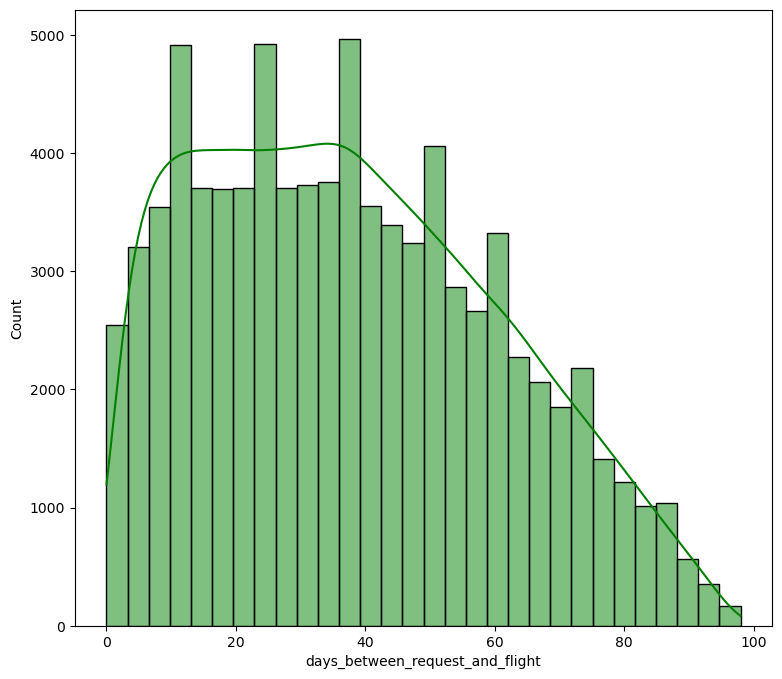

In [418]:
# check the distribution of the number of days between request date and flight date
df_train_copy['days_between_request_and_flight'] = (df_train_copy['Flight_Date'] - df_train_copy['Request_Date']).dt.days

plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['days_between_request_and_flight'], color='g', kde=True, bins=30);

# get the min, max, mean and median of the number of days between request date and flight date
print(df_train_copy['days_between_request_and_flight'].describe())

### Departure Hour ###

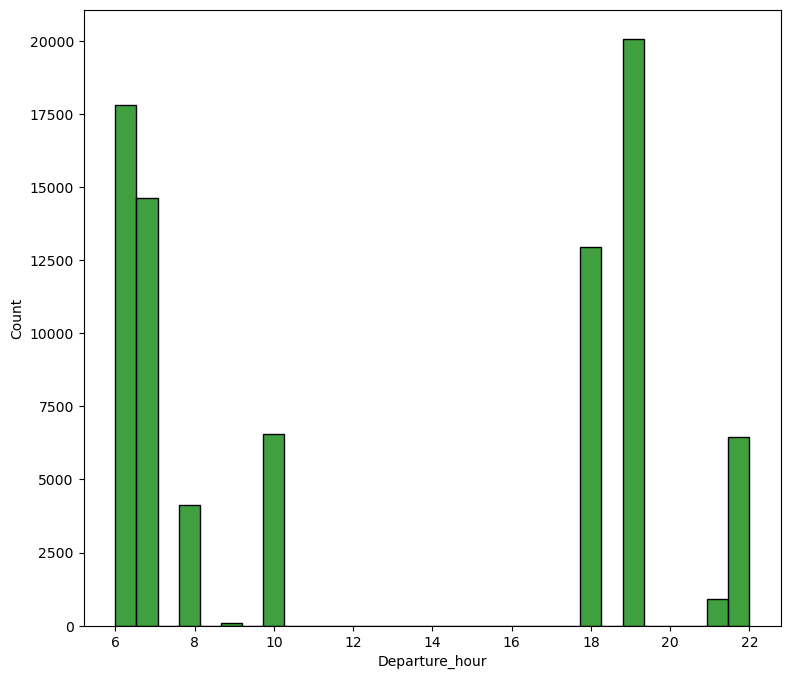

In [419]:
# check the distribution of Departure hour
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Departure_hour'], color='g');

In [420]:
# check the amounts of data with Departure hour between 12 and 16
df_train_copy[(df_train_copy['Departure_hour'] >= 12) & (df_train_copy['Departure_hour'] <= 16)].shape[0]

0

The earliest flights depart at 6, the latest at 22. Most flights seem to depart in the morning or in the evening. There are no flights departing in the afternoon between 12 and 16.

### New Feature: Is Holiday ###

As it is possible that the price of flights is higher on bank holidays or during school holidays, a new feature is added to the data: is_holiday. 

#### Bank Holidays ####

The data for the bank holidays is taken from https://pypi.org/project/holidays/. The data contains bank holidays for different countries. The data for holidays in germany and uk is then merged with the data from the flights.

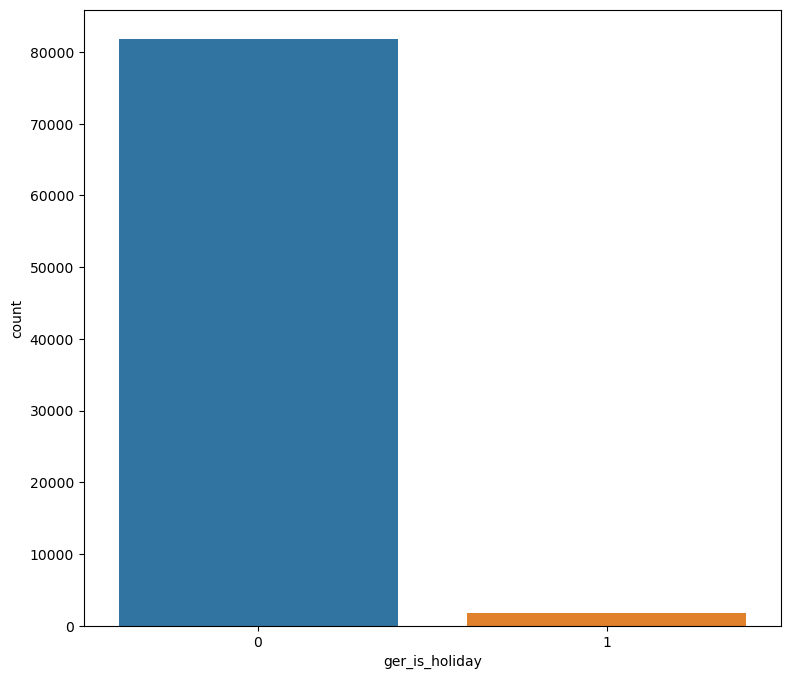

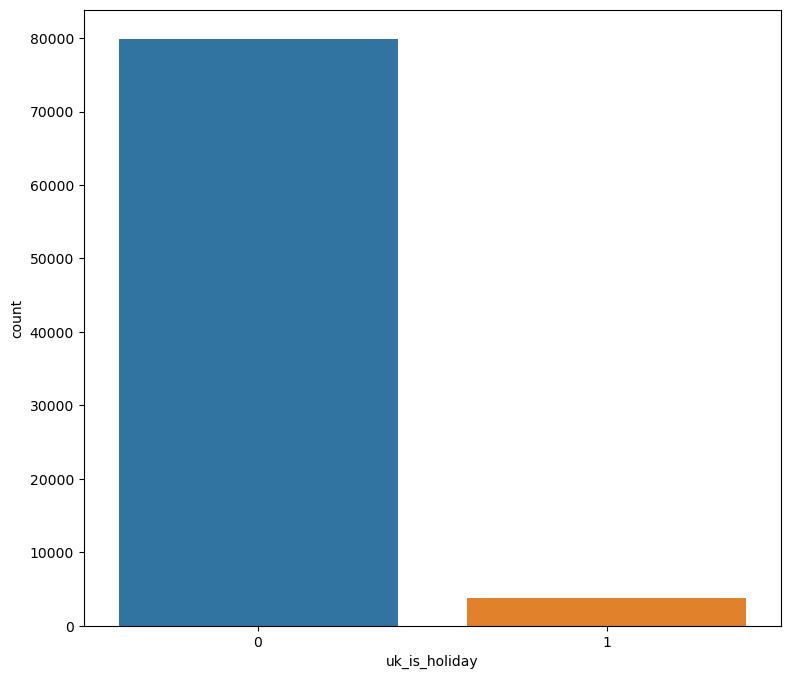

In [421]:
from datetime import date
import holidays

ger_holidays = holidays.GR()
# create a function to check if a date is a holiday in germany
def is_holiday_ger(date):
    if date in ger_holidays:
        return 1
    else:
        return 0
    
# create a new column with the holiday information
df_train_copy['ger_is_holiday'] = df_train_copy['Flight_Date'].apply(is_holiday_ger)

# check the distribution of is_holiday
plt.figure(figsize=(9, 8)) 
sns.countplot(x='ger_is_holiday', data=df_train_copy);


uk_holidays = holidays.UK()
# create a function to check if a date is a holiday in the UK
def is_holiday_uk(date):
    if date in uk_holidays:
        return 1
    else:
        return 0

# create a new column with the holiday information
df_train_copy['uk_is_holiday'] = df_train_copy['Flight_Date'].apply(is_holiday_uk)

# check the distribution of is_holiday
plt.figure(figsize=(9, 8))
sns.countplot(x='uk_is_holiday', data=df_train_copy);

Because there are only a few holidays in the data, the two holiday columns are combined to one column. The new column contains the information if the flight is on a holiday (it doesn't matter if in the departure or arrival country) or not.

In [422]:
# define a function to check if a date is a holiday in the UK or Germany
def is_holiday_uk_ger(date):
    if date in ger_holidays or date in uk_holidays:
        return 1
    else:
        return 0

In [423]:
# merge the two holiday columns into one
df_train_copy['is_holiday'] = df_train_copy['ger_is_holiday'] + df_train_copy['uk_is_holiday']

# drop the two holiday columns
df_train_copy.drop(['ger_is_holiday', 'uk_is_holiday'], axis=1, inplace=True)

TODO: Extended bank holidays to include the days before and after the bank holidays. This is done because it is possible that the prices are higher on the days before and after the bank holidays.

#### School holidays ####

Flight prices may be higher during the school holidays, because more people have the opportunity to go on vacation. Because the flights arrival and departure airports are in Germany and UK, the school holidays for these countries are added to the data. Because in Germany the school holidays are different for each state, the school holidays for the state of the departure airport are added to the data, meaning Berlin (and Brandenburg because it is close to Berlin) and Nordrhein-Westfalen (NRW). Only if the flight is in the school holidays of the departure or arrival airport, the flight is marked as a flight during the school holidays.
 The school holidays are taken from following websites:
-  NRWhttps://www.schulferien.org/deutschland/ferien/2019/ (visited 10.07.2023)
-  https://world-schools.com/de/school-holidays-in-the-uk-in-2019/ (visited 10.07.2023)

Index(['index', 'Request_Date', 'Flight_Date', 'Departure_hour',
       'flight_unique_id', 'route_abb', 'Price_In_Eur',
       'min_future_price_in_Eur', 'buy', 'Request_Month',
       'Request_Day_Of_Week', 'Request_is_Weekend', 'Request_Hour',
       'Flight_Month', 'Flight_Day_Of_Week', 'days_between_request_and_flight',
       'is_holiday'],
      dtype='object')


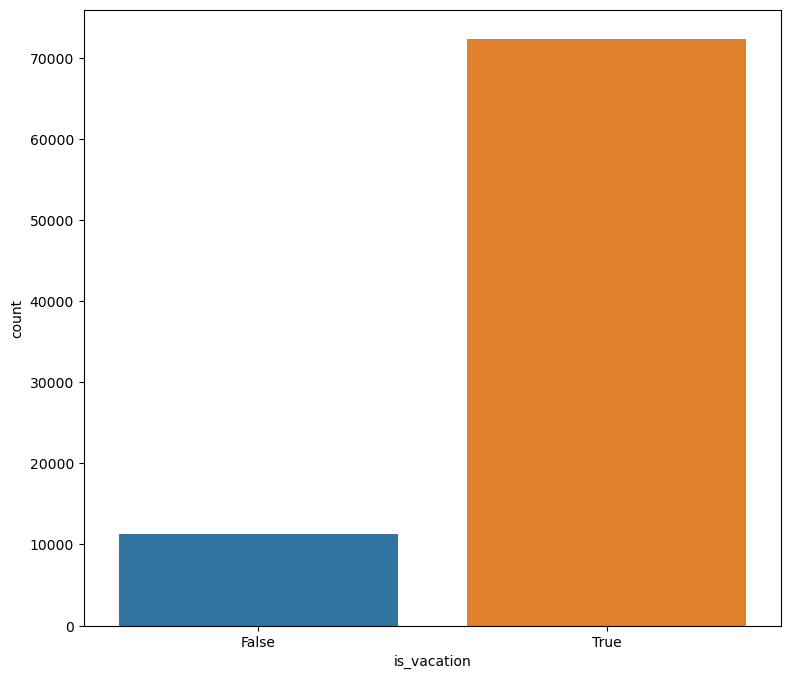

In [424]:
print(df_train_copy.columns)
# add school holidays of NRW, Berlin, Brandenburg and England
# Define the vacation periods with associated airports
vacations = [
    {'start': '2019-07-15', 'end': '2019-08-27', 'airports': ['FRA']},  # NRW
    {'start': '2019-05-31', 'end': '2019-06-11', 'airports': ['SXF']},  # Berlin
    {'start': '2019-06-20', 'end': '2019-08-02', 'airports': ['SXF']},  # Berlin
    {'start': '2019-06-20', 'end': '2019-08-03', 'airports': ['SXF']},  # Brandenburg
    {'start': '2019-07-15', 'end': '2019-09-06', 'airports': ['STN']}   # England
]

# Convert the start and end dates to datetime
for vacation in vacations:
    vacation['start'] = pd.to_datetime(vacation['start'])
    vacation['end'] = pd.to_datetime(vacation['end'])

# Extract the Departure_airport and Arrival_airport from the route_abb column
df_train_copy['departure_airport'] = df_train_copy['route_abb'].str[:3]
df_train_copy['arrival_airport'] = df_train_copy['route_abb'].str[-3:]

# Initialize a new column 'is_vacation' with False
df_train_copy['is_vacation'] = False

# Set 'is_vacation' to True if the flight date is within any of the vacation periods and the origin or destination airport is associated with the vacation
for vacation in vacations:
    df_train_copy.loc[(df_train_copy['Flight_Date'] >= vacation['start']) & (df_train_copy['Flight_Date'] <= vacation['end']) & ((df_train_copy['departure_airport'].isin(vacation['airports'])) | (df_train_copy['arrival_airport'].isin(vacation['airports']))), 'is_vacation'] = True

# Display the first few rows of the dataframe
df_train_copy.head()

# drop the departure and arrival airport columns
df_train_copy.drop(['departure_airport', 'arrival_airport'], axis=1, inplace=True)

# plot the distribution of is_vacation
plt.figure(figsize=(9, 8))
sns.countplot(x='is_vacation', data=df_train_copy);

#### Merge bank holidays and school holidays ####

In [425]:
# merge the columns 'is_holiday' and 'is_vacation' into one column
df_train_copy['is_holiday'] = df_train_copy['is_holiday'] + df_train_copy['is_vacation']

# drop the column 'is_vacation'
df_train_copy.drop('is_vacation', axis=1, inplace=True)

### Route Abb ###

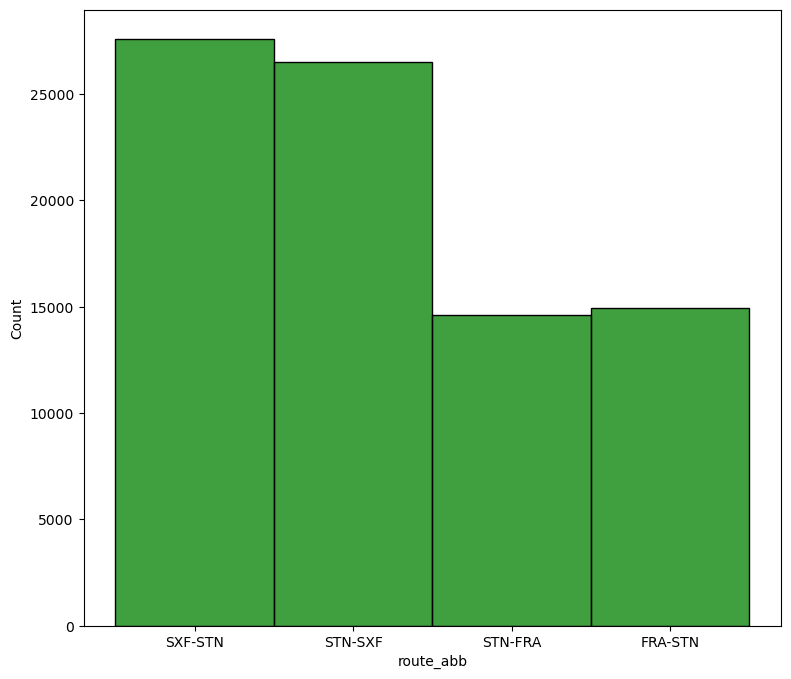

In [426]:
# check the distribution of route abb
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['route_abb'], color='g');

The data contains 2 routes: SXF-STN and STN-FRA additionally for both of those routes there are flights in both directions. There are a little more than 10000 more flights from STN-SXF/SXF-STN than from FRA-STN/STN-FRA.

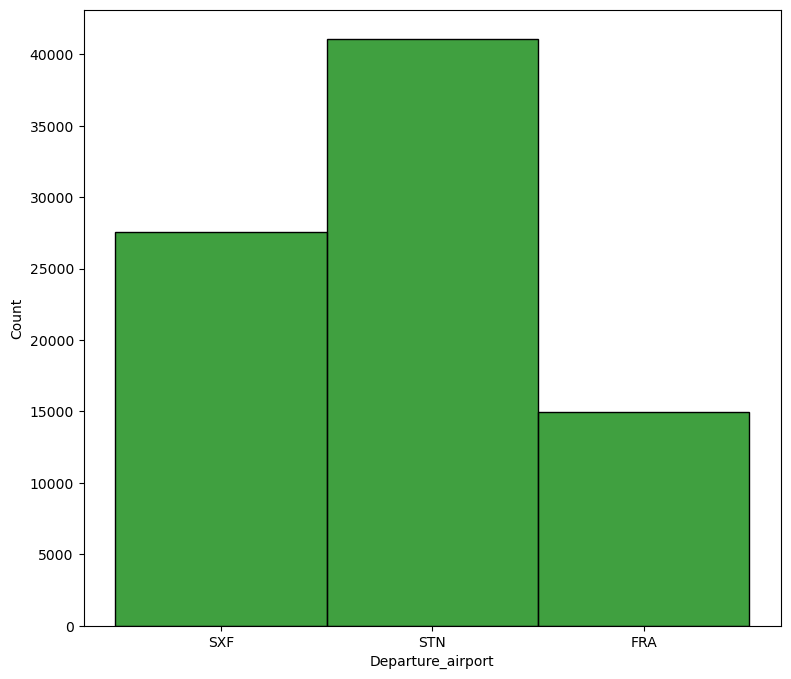

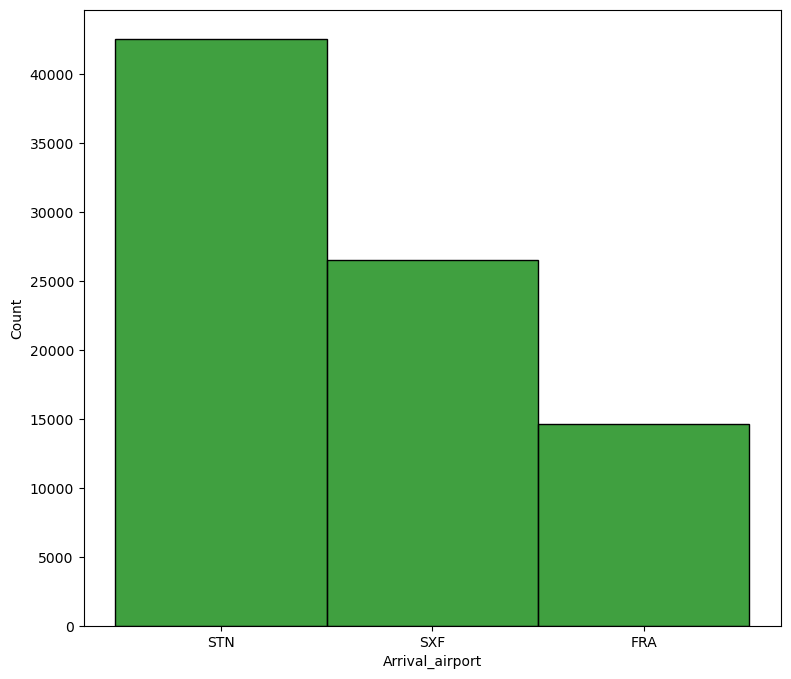

In [427]:
# Extract the departure and arrival airports from the route_abb column
df_train_copy['Departure_airport'] = df_train_copy['route_abb'].str.split('-').str[0]
df_train_copy['Arrival_airport'] = df_train_copy['route_abb'].str.split('-').str[1]

# check the distribution of Departure airport
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Departure_airport'], color='g');

# check the distribution of Arrival airport
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Arrival_airport'], color='g');

### Buy ###

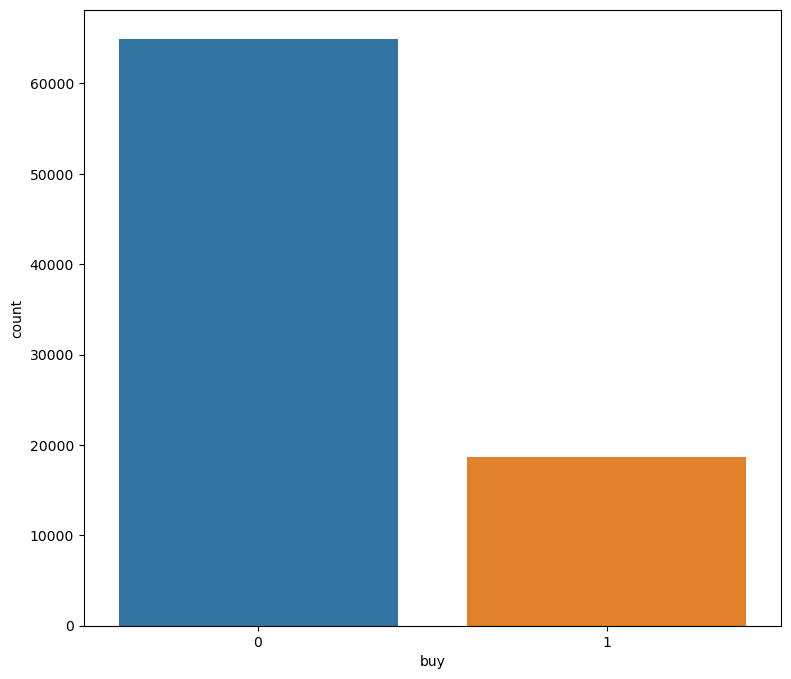

In [428]:
# check the distribution of buy
plt.figure(figsize=(9, 8))
sns.countplot(x='buy', data=df_train_copy);

There are more than three times more requests where the flight is currently not recommended to be bought than requests where the flight is recommended to be bought.

There are between 0 and 98 days between the request date and the flight date.

### Flight Unique Id ###

1007


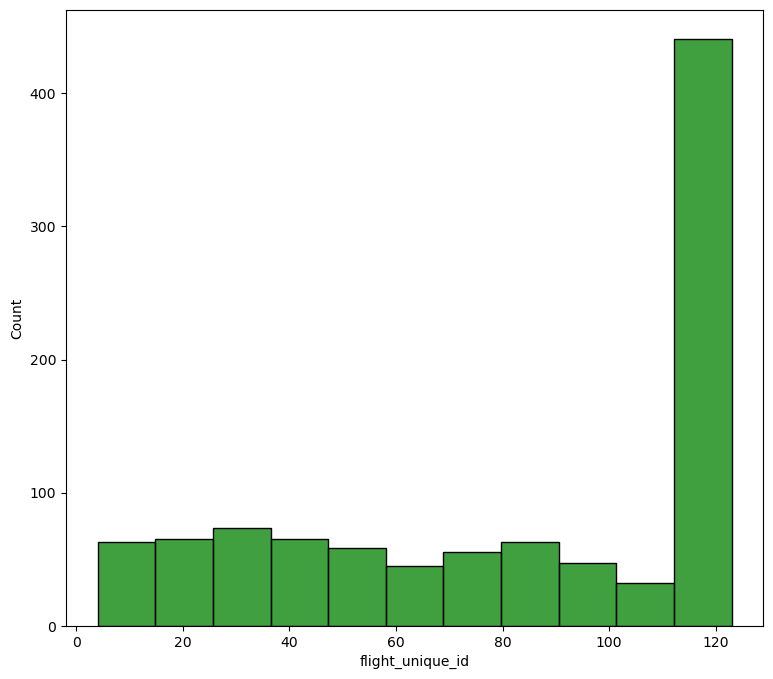

In [429]:
# check how many different flights are in the data
print(df_train_copy['flight_unique_id'].nunique())

# plot the number of requests for each flight
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['flight_unique_id'].value_counts(), color='g');

### New Feature: Current Price Trend ###

The current price trend may be a relevant information. If the price is currently rising, it may be better to buy the flight now. If the price is currently falling, it may be better to wait a little longer.

In [430]:
# function to calculate the current price trend
def price_trend(df):
    # calculate the rolling average of the last 3 prices for each flight
    df['rolling_mean_price'] = df.groupby('flight_unique_id')['Price_In_Eur'].rolling(window=5).mean().reset_index(0, drop=True)

    # calculate the price difference between the current price and the rolling average price
    df['avg_price_difference'] = df['Price_In_Eur'] - df['rolling_mean_price']

    # create a new column 'avg_price_trend' based on the sign of the 'avg_price_difference'
    # positive difference indicates an upward trend (1), negative difference indicates a downward trend (-1) an zero indicates a stable trend (0)
    df['price_trend'] = df['avg_price_difference']

    # replace the NaN values in the 'avg_price_trend' column with 0
    df['price_trend'] = df['price_trend'].fillna(0)

    # drop the 'rolling_mean_price' and 'avg_price_difference' columns
    df = df.drop(['rolling_mean_price', 'avg_price_difference'], axis=1)

price_trend(df_train_copy)
# drop 'rolling_mean_price' and 'avg_price_difference'
df_train_copy.drop(['rolling_mean_price', 'avg_price_difference'], axis=1, inplace=True)

In [431]:
df_train_copy.tail()

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,min_future_price_in_Eur,buy,Request_Month,Request_Day_Of_Week,Request_is_Weekend,Request_Hour,Flight_Month,Flight_Day_Of_Week,days_between_request_and_flight,is_holiday,Departure_airport,Arrival_airport,price_trend
83619,83620,2019-08-01 11:00:00,2019-09-10,10,2019-09-10 FR 8543,SXF-STN,35.69,39.69,1,8,3,False,11,9,1,39,0,SXF,STN,1.224
83620,83621,2019-08-01 23:00:00,2019-09-10,10,2019-09-10 FR 8543,SXF-STN,46.83,39.69,0,8,3,False,23,9,1,39,0,SXF,STN,8.912
83621,83622,2019-08-02 11:00:00,2019-09-10,10,2019-09-10 FR 8543,SXF-STN,46.83,39.69,0,8,4,False,11,9,1,38,0,SXF,STN,6.684
83622,83623,2019-08-02 23:00:00,2019-09-10,10,2019-09-10 FR 8543,SXF-STN,39.69,39.69,1,8,4,False,23,9,1,38,0,SXF,STN,-1.256
83623,83624,2019-08-03 11:00:00,2019-09-10,10,2019-09-10 FR 8543,SXF-STN,39.69,39.69,1,8,5,True,11,9,1,37,0,SXF,STN,-2.056


### Summary ###

The distribution of the number of requests per flight shows that a small number of flights account for a disproportionately high share of total requests, while the majority of flights receive only a small number of requests.

The data exploration so far showed that:
-  There are no duplicates in the data
-  There are no missing values in the data
-  *Request_date* and *Flight_date* are of type object, but should be of type datetime. Request date contained the timezone information, which was removed. The data was then converted to datetime.
-  *Price_In_Eur*:
    -  The distribution is right-skewed, with most of the flight prices being less than 100 EUR. There are also some flights with prices up to around 375 EUR, but these are less common.
-  *Min_future_price_in_Eur*:
    -  The distribution is similar to that of 'Price_In_Eur', being right-skewed with most of the minimum future prices being less than 100 EUR. There are also some flights with minimum future prices up to around 300 EUR, but these are less common.
-  *Request_Date*:
    -  the data contains *Request_date*s from 2019-06-03 to 2019-08-03. There are no outliers. <br>
    The data only contains requests of the months 6, 7 and 8, meaning June, July and August. The Month with the most requests is June, a little less in July and only a few in August. <br>
    There are nearly the same amount of requests on each day of the week. There are no outliers.
-  *Flight_Date*:
    -  the first *Flight_date* is on 2019-06-05 and the last flight on 2019-09-10. There are no outliers.
-  *Departure_hour*:
    -  the flights depart between 6 and 22, most of them in the morning or in the evening, none between 12 and 16. There are no outliers.
-  *Route_abb*:
    -  the data contains 2 routes in *route_abb* with flights in both directions, so 4 routes: SXF-STN and STN-FRA. There are around 1.5 times more flights from STN-SXF/SXF-STN than from FRA-STN/STN-FRA. There are no outliers.
-  *Buy*:
    -  there are more than three times more flights that currently are recommended not to *buy* than flights that should be bought.
-  *Flight_unique_id*:
    -  the distribution of the number of requests per flight shows that a small number of flights account for a disproportionately high share of total requests, while the majority of flights receive only a small number of requests.

### Looking for Correlations ###

Check for correlation between the variables. Because min_future_price_in_eur or buy are the target variables, we will now check for correlation between them and the other variables. min_future_price_in_eur or buy are the target variables we may want to predict, because we want to predict if a customer currently should buy a flight or not or a company now should give a reccomendation to buy a flight or not. If we learn to predict the minimum future price, we can use this to say if a flight should currently be bought or if it gets cheaper in the future. If we learn to predict if a flight should currently be bought (meaning target variable buy), we can use this to directly give a recommendation to buy a flight or not.

In [432]:
# print the column names
print(df_train_copy.columns)

Index(['index', 'Request_Date', 'Flight_Date', 'Departure_hour',
       'flight_unique_id', 'route_abb', 'Price_In_Eur',
       'min_future_price_in_Eur', 'buy', 'Request_Month',
       'Request_Day_Of_Week', 'Request_is_Weekend', 'Request_Hour',
       'Flight_Month', 'Flight_Day_Of_Week', 'days_between_request_and_flight',
       'is_holiday', 'Departure_airport', 'Arrival_airport', 'price_trend'],
      dtype='object')


In [433]:
# check the correlation between the features and the target variable 'buy'
corr_matrix = df_train_copy.corr()
corr_matrix['buy'].sort_values(ascending=False)

buy                                1.000000
min_future_price_in_Eur            0.197882
Request_Month                      0.095869
Request_Day_Of_Week                0.022429
Departure_hour                    -0.000522
Request_is_Weekend                -0.002159
Flight_Day_Of_Week                -0.014860
Request_Hour                      -0.020099
is_holiday                        -0.033718
Price_In_Eur                      -0.038199
price_trend                       -0.103779
Flight_Month                      -0.117909
index                             -0.121130
days_between_request_and_flight   -0.224999
Name: buy, dtype: float64

In [434]:
# check the correlation between the features and the target variable 'min_future_price_in_Eur'
corr_matrix = df_train_copy.corr()
corr_matrix['min_future_price_in_Eur'].sort_values(ascending=False)

min_future_price_in_Eur            1.000000
Price_In_Eur                       0.894554
price_trend                        0.239258
buy                                0.197882
Request_Month                      0.177996
Flight_Day_Of_Week                 0.097273
Departure_hour                     0.083496
Request_Day_Of_Week                0.007517
is_holiday                        -0.004934
Request_is_Weekend                -0.005590
Request_Hour                      -0.008186
Flight_Month                      -0.395865
index                             -0.409284
days_between_request_and_flight   -0.563969
Name: min_future_price_in_Eur, dtype: float64

In [435]:
# # TODO: pandas profiling
# # https://towardsdatascience.com/exploratory-data-analysis-with-pandas-profiling-de3aae2ddff3

# from pandas_profiling import ProfileReport
# prof = ProfileReport(df_train_copy, correlations={
#     "pearson": {"calculate": True},
#     "spearman": {"calculate": True},
#     "kendall": {"calculate": True},
#     "phi_k": {"calculate": True},
#     "cramers": {"calculate": True},
# })
# prof.to_file(output_file='output.html')

#### Scatterplot ####

Scatterplot to look for conspicuities of the most correlated features in the data.

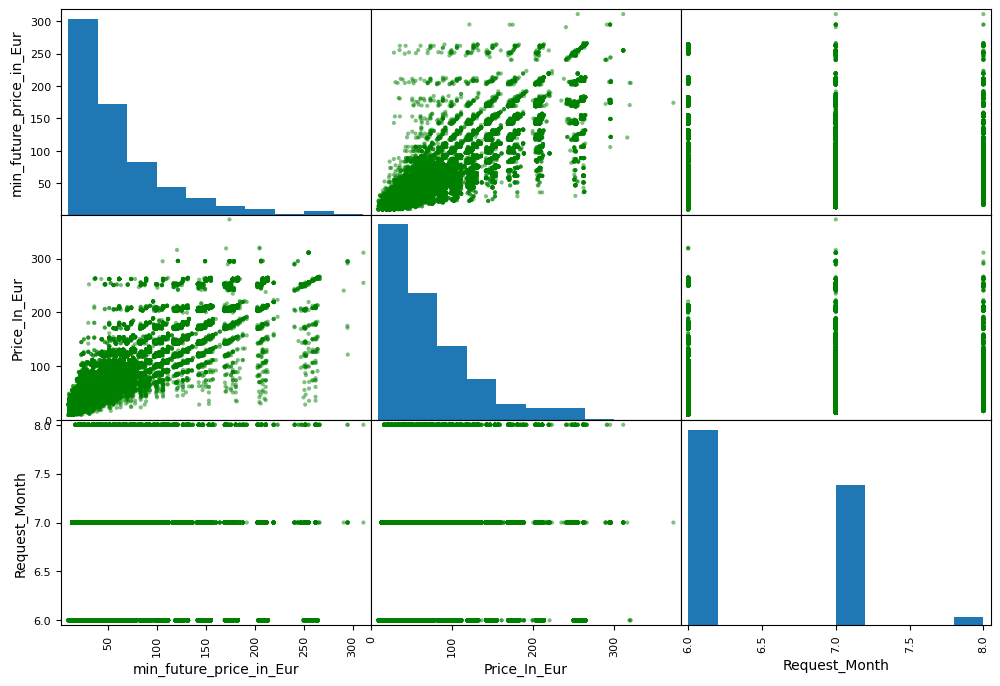

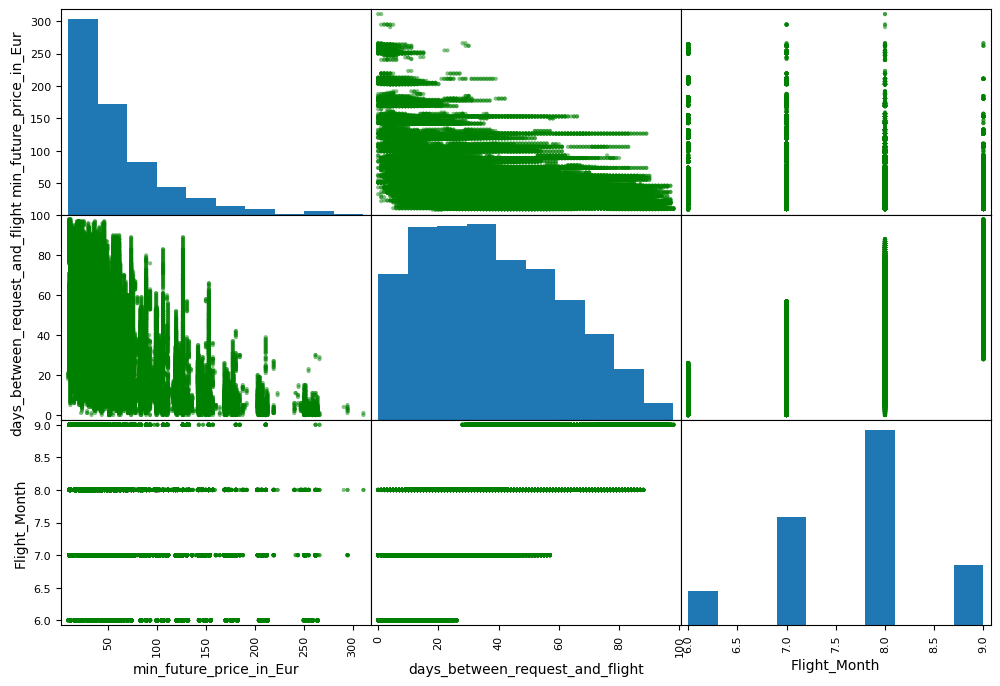

In [436]:
# plot the scatter matrix for min_future_price_in_Eur and the features with the highest correlation
attributes = ['min_future_price_in_Eur', 'Price_In_Eur', 'Request_Month']
scatter_matrix(df_train_copy[attributes], figsize=(12, 8), color='g');

attributes = ['min_future_price_in_Eur', 'days_between_request_and_flight', 'Flight_Month']
scatter_matrix(df_train_copy[attributes], figsize=(12, 8), color='g');

#### Correlation Matrix ####

Correlation matrix to look for correlations between the features and the target variables.

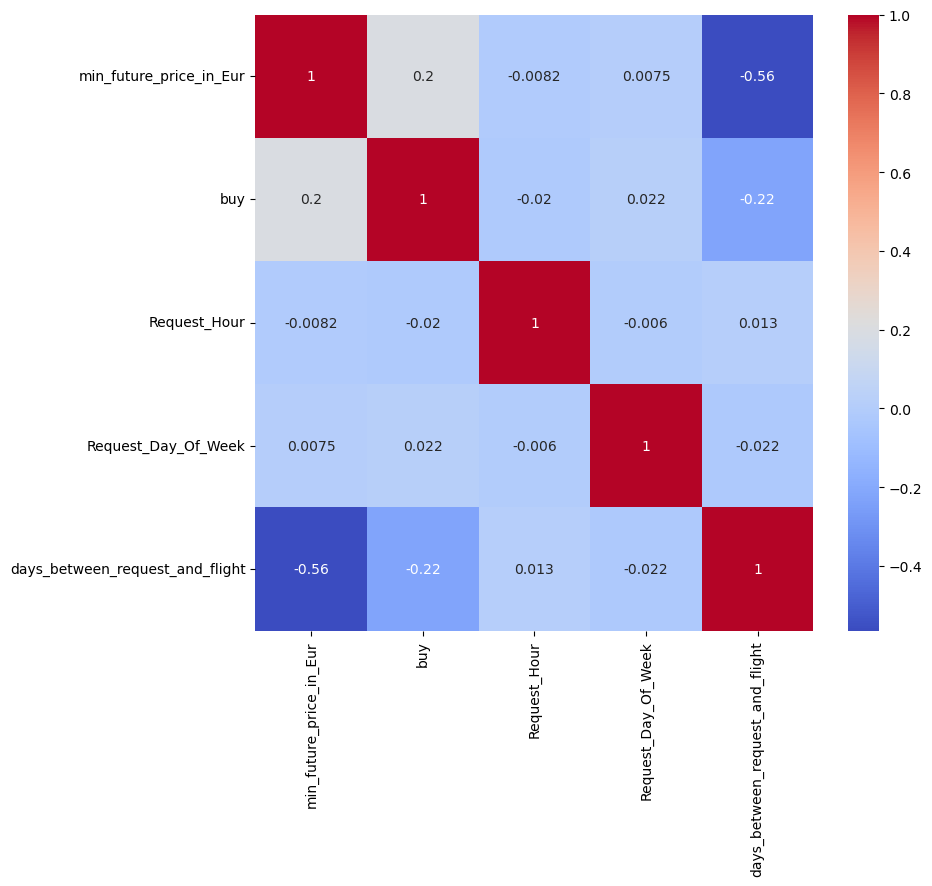

In [437]:
# Correlation matrix for min_future_price_in_eur, buy and the request related columns
corr_matrix = df_train_copy[['min_future_price_in_Eur', 'buy', 'Request_Hour', 'Request_Day_Of_Week', 'days_between_request_and_flight']].corr()

# plot the correlation matrix
plt.figure(figsize=(9, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm');

-  -0.56 (strong negativ correlation): min_future_price_in_eur and days_between_request_and_flight_date
-  -0.22 (negativ correlation): buy and days_between_request_and_flight_date

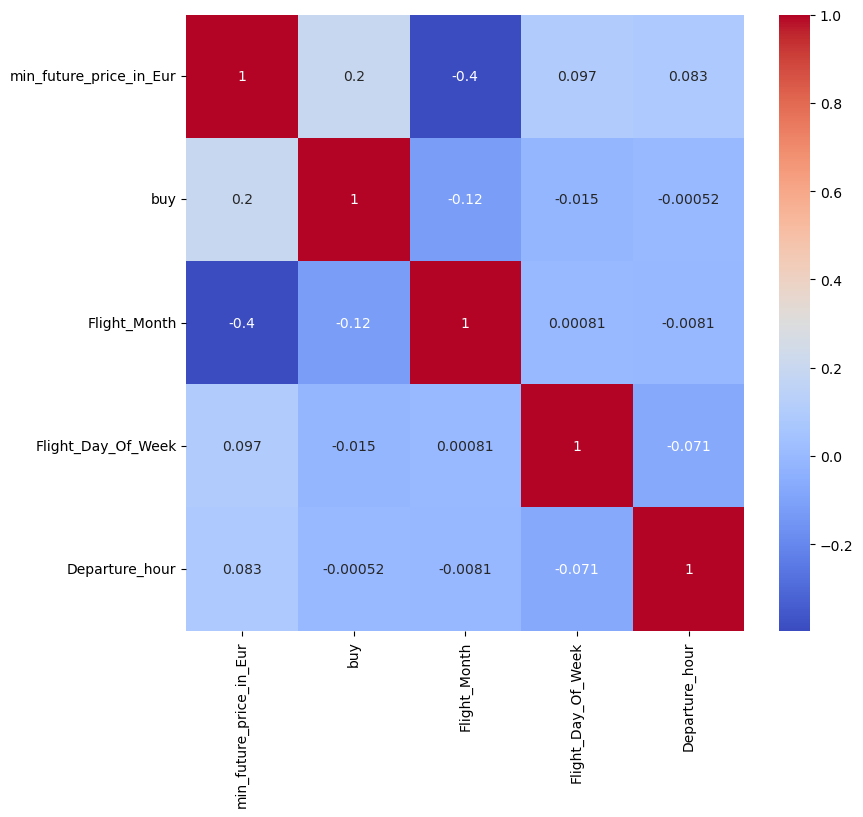

In [438]:
# Correlation matrix for min_future_price_in_eur, buy and the flight related columns
corr_matrix = df_train_copy[['min_future_price_in_Eur', 'buy', 'Flight_Month', 'Flight_Day_Of_Week', 'Departure_hour']].corr()

# plot the correlation matrix
plt.figure(figsize=(9, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm');

-  -0.44 (strong negativ correlation): min_future_price_in_eur and Flight_month
-  -0.12 (negativ correlation): buy and Flight_month
-  0.097 (small positive correlation): Flight_day_of_week and min_future_price_in_eur
-  0.083 (small positive correlation): Departure_hour and min_future_price_in_eur

#### (Aktuell noch Route_Abb)Correlations for Categorical Variables ####

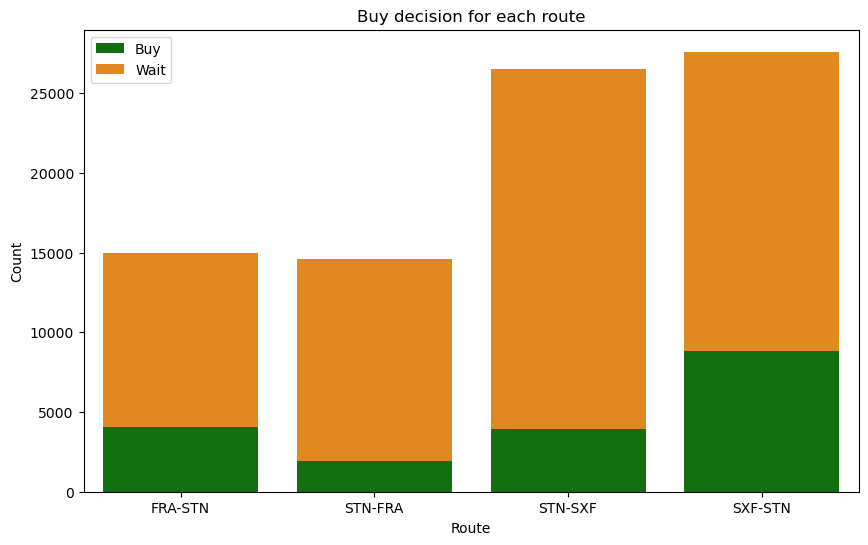

In [439]:
# Check the correlation between route_abb and the target variable 'buy'
buy_route_counts = df_train_copy.groupby(['route_abb', 'buy']).size().unstack()

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=buy_route_counts.index, y=buy_route_counts[1], label='Buy', color='g')
sns.barplot(x=buy_route_counts.index, y=buy_route_counts[0], bottom=buy_route_counts[1], label='Wait', color='darkorange')

plt.xlabel('Route')
plt.ylabel('Count')
plt.title('Buy decision for each route')
plt.legend()
plt.show()

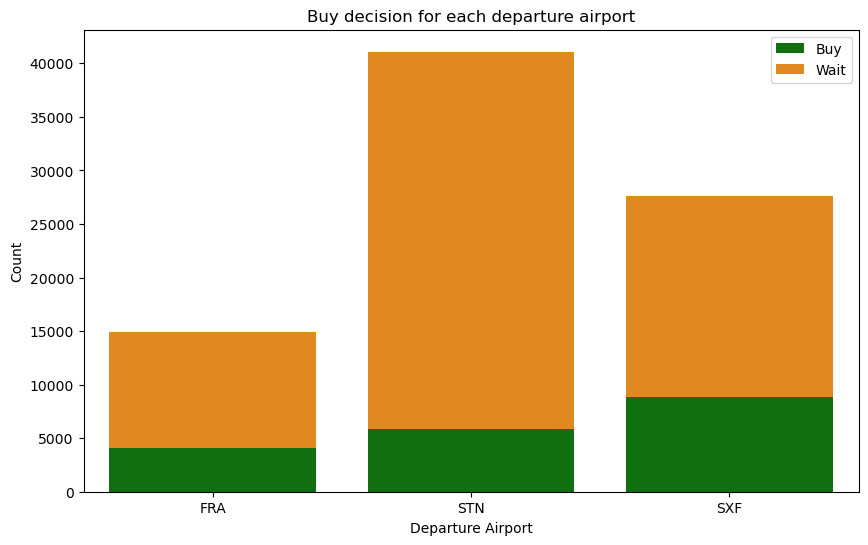

In [440]:
# check the correlation between departure_airport and the target variable 'buy'
buy_dep_airport_counts = df_train_copy.groupby(['Departure_airport', 'buy']).size().unstack()

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=buy_dep_airport_counts.index, y=buy_dep_airport_counts[1], label='Buy', color='g')
sns.barplot(x=buy_dep_airport_counts.index, y=buy_dep_airport_counts[0], bottom=buy_dep_airport_counts[1], label='Wait', color='darkorange')

plt.xlabel('Departure Airport')
plt.ylabel('Count')
plt.title('Buy decision for each departure airport')
plt.legend()
plt.show()

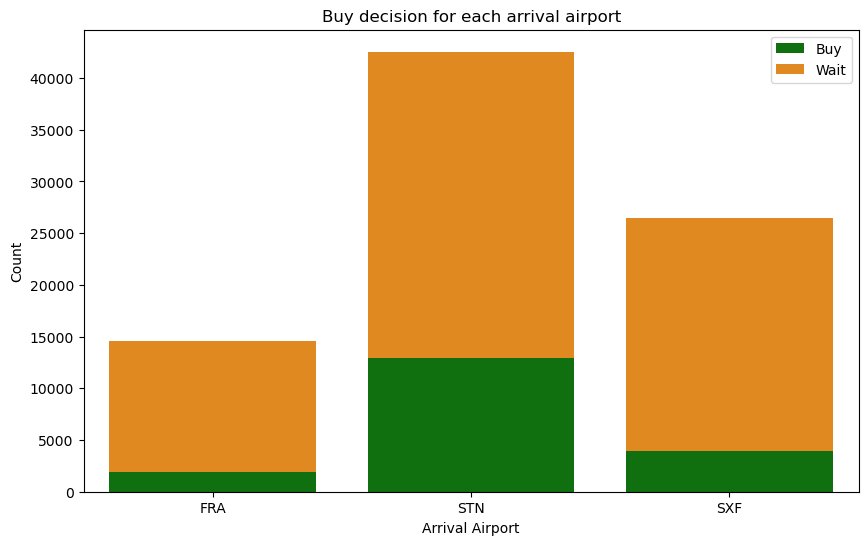

In [441]:
# check the correlation between arrival_airport and the target variable 'buy'
buy_arr_airport_counts = df_train_copy.groupby(['Arrival_airport', 'buy']).size().unstack()

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=buy_arr_airport_counts.index, y=buy_arr_airport_counts[1], label='Buy', color='g')
sns.barplot(x=buy_arr_airport_counts.index, y=buy_arr_airport_counts[0], bottom=buy_arr_airport_counts[1], label='Wait', color='darkorange')

plt.xlabel('Arrival Airport')
plt.ylabel('Count')
plt.title('Buy decision for each arrival airport')
plt.legend()
plt.show()

There seems to be no big influence of the departure and arrival airport on the buy decision. Therefore we will not use the departure and arrival airport in the model.

In [442]:
# remove 'departure_airport' and 'arrival_airport' from the data
df_train_copy.drop(['Departure_airport', 'Arrival_airport'], axis=1, inplace=True)

### Select most important features ###

Additionally to the correlation matrix, we will now use a method to find the most important features for the model based on the results of SelectKBest.

#### SelectKBest for Regression ####

In [443]:
# feature selection with sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression 

# copy the data
df_train_copy2 = df_train_copy.copy()

# separate the features and the target variable 'min_future_price_in_Eur'
X = df_train_copy2.drop(['min_future_price_in_Eur', 'Request_Date', 'Flight_Date', 'flight_unique_id'], axis=1)
y = df_train_copy2['min_future_price_in_Eur']

# convert the categorical columns to numerical
X = pd.get_dummies(X)

# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_regression, k=16) # 16 features
fit = bestfeatures.fit(X, y)

# create a dataframe with the scores
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat the two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']

# print the 10 best features
featureScores.nlargest(16, 'Score')


,Specs,Score
0,index,5.161506
2,Price_In_Eur,2.815317
1,Departure_hour,0.796740
12,price_trend,0.747682
9,Flight_Day_Of_Week,0.659728
10,days_between_request_and_flight,0.567892
8,Flight_Month,0.563434
15,route_abb_STN-SXF,0.496516
16,route_abb_SXF-STN,0.449214
4,Request_Month,0.365459


It seems that the 10 most promising columns for predicting the minimum future price are:
-  Price_In_Eur
-  Departure_hour
-  Flight_Day_Of_Week
-  days_between_request_and_flight
-  Flight_Month
-  route_abb_STN-SXF
-  route_abb_SXF-STN
-  Request_Month
-  route_abb_STN-FRA
-  route_abb_FRA-STN

These results align with the results from the correlation matrixes. This means following features will be used in the model:
-  *Price_In_Eur*
-  *Departure_hour*
-  *Flight_Day_Of_Week*
-  *days_between_request_and_flight*
-  *Flight_Month*
-  *route_abb* (OneHotEncoded)
-  *Request_Month*

#### SelectKBest for Classification ####

In [444]:
# feature selection with sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif 

# copy the data
df_train_copy3 = df_train_copy.copy()

# separate the features and the target variable 'min_future_price_in_Eur'
X = df_train_copy3.drop(['buy', 'Request_Date', 'Flight_Date', 'flight_unique_id'], axis=1)
Y = df_train_copy3['buy']

print(df_train_copy3.columns)

# convert the categorical columns to numerical
X = pd.get_dummies(X)

# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_classif , k=16)
fit = bestfeatures.fit(X, Y)

# create a dataframe with the scores
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat the two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']

# print the 10 best features
featureScores.nlargest(16, 'Score')


Index(['index', 'Request_Date', 'Flight_Date', 'Departure_hour',
       'flight_unique_id', 'route_abb', 'Price_In_Eur',
       'min_future_price_in_Eur', 'buy', 'Request_Month',
       'Request_Day_Of_Week', 'Request_is_Weekend', 'Request_Hour',
       'Flight_Month', 'Flight_Day_Of_Week', 'days_between_request_and_flight',
       'is_holiday', 'price_trend'],
      dtype='object')


,Specs,Score
0,index,0.277443
3,min_future_price_in_Eur,0.084519
2,Price_In_Eur,0.081052
12,price_trend,0.048988
10,days_between_request_and_flight,0.036852
16,route_abb_SXF-STN,0.015448
4,Request_Month,0.015300
1,Departure_hour,0.014603
8,Flight_Month,0.011578
15,route_abb_STN-SXF,0.010802


## Prepare the data (Data Preparation) ##

In [445]:
# copy the data again from the original dataframe
df_train_copy = df_train.copy()

### 1. Data cleaning ###

-  No removing of outliers, because there are no outliers in the data.
-  No filling of missing values, because there are no missing values in the data.

### 2. Feature selection ###

We will now select the features that we may want to use for the model. We will try out different combinations of features and see which combination gives the best results.

-  Remove *index* because it is not needed anymore.

In [446]:
# drop the columns that are not needed
df_train_copy.drop(['index'], axis=1, inplace=True)

### 3. Feature Engineering ###

-  Encode *route_abb* with OneHotEncoder.
-  Convert *Request_date* and *Flight_date* to datetime. Remove timezone information from *Request_date*.
-  Create *days_between_request_and_flight_date* from *Request_date* and *Flight_date*.
-  Create *Request_Month* from *Request_date*. Then remove *Request_date*.
-  Create *Flight_Month* and *Flight_Day_Of_Week* from *Flight_date*. Then remove *Flight_date*.

In [447]:
# One hot encoding for route_abb
df_train_copy = pd.get_dummies(df_train_copy, columns=['route_abb'], prefix = ['route_abb'])

In [448]:
# convert Request date to datetime
df_train_copy['Request_Date'] = pd.to_datetime(df_train_copy['Request_Date'])

# remove the timezone from the request date
df_train_copy['Request_Date'] = df_train_copy['Request_Date'].dt.tz_convert(None)

# convert Flight date to datetime
df_train_copy['Flight_Date'] = pd.to_datetime(df_train_copy['Flight_Date'])

In [449]:
# flight day of week
df_train_copy['Flight_Day_of_Week'] = df_train_copy['Flight_Date'].dt.dayofweek

In [450]:
# create column days_between_request_and_flight
df_train_copy['days_between_request_and_flight'] = (df_train_copy['Flight_Date'] - df_train_copy['Request_Date']).dt.days

In [451]:
# create column 'is_holiday'
df_train_copy['is_holiday'] = df_train_copy['Flight_Date'].apply(is_holiday_uk_ger)

In [452]:
# create column 'is_weekend'
df_train_copy['is_weekend'] = df_train_copy['Request_Date'].dt.weekday >= 5

In [453]:
# create column Flight_month
df_train_copy['Flight_Month'] = df_train_copy['Flight_Date'].dt.month

# remove the Flight_Date column
df_train_copy.drop(['Flight_Date'], axis=1, inplace=True)

In [454]:
# create Request_Month column
df_train_copy['Request_Month'] = df_train_copy['Request_Date'].dt.month

In [455]:
# create column 'price_trend'
price_trend(df_train_copy)
df_train_copy['price_trend'] = df_train_copy.groupby('flight_unique_id')['Price_In_Eur'].diff()


# delete the column 'rolling_mean_price' and 'avg_price_difference'
df_train_copy.drop(['rolling_mean_price', 'avg_price_difference'], axis=1, inplace=True)

In [456]:
# delete the column 'flight_unique_id'
# df_train_copy.drop(['flight_unique_id'], axis=1, inplace=True)

In [457]:
# check the new df_train_price dataframe
df_train_copy.head()

,Request_Date,Departure_hour,flight_unique_id,Price_In_Eur,min_future_price_in_Eur,buy,route_abb_FRA-STN,route_abb_STN-FRA,route_abb_STN-SXF,route_abb_SXF-STN,Flight_Day_of_Week,days_between_request_and_flight,is_holiday,is_weekend,Flight_Month,Request_Month,price_trend
0,2019-06-03 11:00:00,19,2019-06-05 FR 146,208.07,259.07,1,0,0,0,1,2,1,0,False,6,6,NaN
1,2019-06-03 23:00:00,19,2019-06-05 FR 146,259.07,259.07,1,0,0,0,1,2,1,0,False,6,6,51.0
2,2019-06-04 11:00:00,19,2019-06-05 FR 146,259.07,259.07,1,0,0,0,1,2,0,0,False,6,6,0.0
3,2019-06-04 23:00:00,19,2019-06-05 FR 146,259.07,259.07,1,0,0,0,1,2,0,0,False,6,6,0.0
4,2019-06-03 11:00:00,21,2019-06-05 FR 147,143.86,251.72,1,0,0,1,0,2,1,0,False,6,6,NaN


We now have the following features for the target variable *min_future_price_in_eur* and *buy*:
-  *Price_In_Eur*
-  *Request_Month*
-  *Departure_hour*
-  *Flight_Day_Of_Week*
-  *days_between_request_and_flight*
-  *Flight_Month*
-  *route_abb* (OneHotEncoded)

### 4. Feature scaling ###

-  Maybe the model will perform better with feature scaling, so we will try it. The features are scaled in the next section.

## Try out different models and find the best ones (Model Selection) ##

### Buy as target variable ###

##### Define the target variable and the features ##### 

In [458]:
df_train_copy

,Request_Date,Departure_hour,flight_unique_id,Price_In_Eur,min_future_price_in_Eur,buy,route_abb_FRA-STN,route_abb_STN-FRA,route_abb_STN-SXF,route_abb_SXF-STN,Flight_Day_of_Week,days_between_request_and_flight,is_holiday,is_weekend,Flight_Month,Request_Month,price_trend
0,2019-06-03 11:00:00,19,2019-06-05 FR 146,208.07,259.07,1,0,0,0,1,2,1,0,False,6,6,NaN
1,2019-06-03 23:00:00,19,2019-06-05 FR 146,259.07,259.07,1,0,0,0,1,2,1,0,False,6,6,51.00
2,2019-06-04 11:00:00,19,2019-06-05 FR 146,259.07,259.07,1,0,0,0,1,2,0,0,False,6,6,0.00
3,2019-06-04 23:00:00,19,2019-06-05 FR 146,259.07,259.07,1,0,0,0,1,2,0,0,False,6,6,0.00
4,2019-06-03 11:00:00,21,2019-06-05 FR 147,143.86,251.72,1,0,0,1,0,2,1,0,False,6,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83619,2019-08-01 11:00:00,10,2019-09-10 FR 8543,35.69,39.69,1,0,0,0,1,1,39,0,False,9,8,0.00
83620,2019-08-01 23:00:00,10,2019-09-10 FR 8543,46.83,39.69,0,0,0,0,1,1,39,0,False,9,8,11.14
83621,2019-08-02 11:00:00,10,2019-09-10 FR 8543,46.83,39.69,0,0,0,0,1,1,38,0,False,9,8,0.00
83622,2019-08-02 23:00:00,10,2019-09-10 FR 8543,39.69,39.69,1,0,0,0,1,1,38,0,False,9,8,-7.14


In [459]:
# No. 1 Define the features and the target
X = df_train_copy[['Price_In_Eur', 'Flight_Day_of_Week', 'Departure_hour', 'Request_Date',
     'days_between_request_and_flight', 'route_abb_FRA-STN', 'route_abb_STN-FRA', 'route_abb_STN-SXF', 'route_abb_SXF-STN', 'price_trend', 'flight_unique_id']]
y = df_train_copy['buy']

# No. 2 Define the features and the target
#X = df_train_copy[['Price_In_Eur', 'Flight_Day_Of_Week', 'Departure_hour', 'Request_Date',
#    'days_between_request_and_flight', 'is_holiday', 'is_weekend', 'price_trend', 'flight_unique_id']]
#y = df_train_copy['buy']

# Split the data into train and test data
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# remove the flight_unique_id from the train and test data
X_train = X_train_full.drop(['flight_unique_id', 'Request_Date'], axis=1)
X_test = X_test_full.drop(['flight_unique_id', 'Request_Date'], axis=1)


##### Model Quality Evaluation Function by Prof. Spott #####

In [460]:
# The model quality evaluation function expects a Pandas dataframe with at least the following columns:
# Request_Date          int64
# flight_unique_id     object
# Price               float64
# buy                    bool

def model_quality_evaluation(df):

    df['Request_Date'] = pd.to_datetime(df['Request_Date'])
    
    # Make a copy of the provided dataframe as to not modify the original.
    df = df.copy()

    # Convert 'Price' to whole cents and store as integers to avoid floating point errors.
    df['Price_In_Eur'] = df['Price_In_Eur'] * 100
    df['Price_In_Eur'] = df['Price_In_Eur'].astype(int)

    # Initialize a variable that stores the sum of all our balances.
    sum_balances = 0

    # Get a list of all 'flight_unique_id'.
    flight_unique_ids = df['flight_unique_id'].unique()

    # Iterate over all 'flight_unique_id'.
    for flight_unique_id in flight_unique_ids:
        # Get a subset of the data for the specified 'flight_unique_id'.
        df_subset = df[df['flight_unique_id'] == flight_unique_id]

        # Get all request dates except for the latest request date before departure.
        # At the latest request date before departure we need to buy a ticket anyway,
        # so we don't care about this specific request date.
        request_dates = df_subset[df_subset['Request_Date'] != df_subset['Request_Date'].max()]

        # Make sure request dates are sorted in descending order.
        request_dates.sort_values(by='Request_Date', ascending=False, inplace=True)

        # Get the ticket price from the latest request date before departure,
        # because we certainly have to buy a ticket at this date.
        last_buying_price = df_subset[df_subset['Request_Date'] == df_subset['Request_Date'].max()]['Price_In_Eur'].values[0]

        # Iterate over the remaining request dates
        for _, row in request_dates.iterrows():
            # and check wether the model wants to buy a ticket at the specific request date.
            if(row['buy'] == True):
                # If the model decides to buy a ticket the last buying price is set to the
                # price point of this request date and the balance doesn't change.
                last_buying_price = row['Price_In_Eur']
            else:
                # If the models decides to not buy a ticket the balance equals the
                # the current ticket price minus the last buying price.
                current_price = row['Price_In_Eur']
                balance = current_price - last_buying_price

                # The balance is added to the sum of all balances.
                sum_balances = sum_balances + balance

    # Return the sum of all our previously calculated balances.
    return sum_balances / 100

#### Sensitivity Analysis ####

To check which score might be useful to optimise the model with respect to the custom model quality, we will perform a sensitivity analysis. We want to examine how much the model quality changes with changes in false negative (FN) and false positive (FP) values.

In this analysis, we set a baseline that randomly generates buy data and adds it to our data set. This baseline serves as a reference for the next steps.
In these steps, we will use cross-validation to test how an increase in false negative and false positive values affects the model quality. Meaning if we increase FN, does the model quality then decreases more than by increasing the FP values.

In [461]:
## Create baseline dataframe

# create random predictions
predictions = np.random.randint(0, 2, size=len(df_train_copy))

# baseline score
baseline_df = df_train_copy.copy()
baseline_df['buy'] = predictions
baseline_score = model_quality_evaluation(baseline_df)

tn, fp, fn, tp = confusion_matrix(df_train_copy['buy'], baseline_df['buy']).ravel()
print('TN: ', tn, 'FP: ', fp, 'FN: ', fn, 'TP: ', tp)

print(baseline_score)

TN:  32214 FP:  32692 FN:  9437 TP:  9281
-85161.86


In [462]:
def calculate_sensitivity():    
    n_fold = 10

    # store custom scores for each fold
    custom_scores_fn_up = []
    custom_scores_fp_up = []

    # iterate over foldss
    for i in range(n_fold):
        df_copy = baseline_df.copy()
        
        # Scenario 1: Increasing FN
        false_negatives = df_copy[(df_copy['buy'] == 0) & (df_train_copy['buy'] == 1)]
        n_to_change = int((len(false_negatives)/3))

        if not false_negatives.empty:
            samples_tp = false_negatives.sample(n=n_to_change)
            df_copy.loc[samples_tp.index, 'buy'] = 1
        custom_score_fn_up = model_quality_evaluation(df_copy)
        custom_scores_fn_up.append(custom_score_fn_up)
        
        # Scenario 2: Increasing FP
        false_positives = df_copy[(df_copy['buy'] == 1) & (df_train_copy['buy'] == 0)]
        n_to_change = int(len(false_positives)/3)

        if not false_positives.empty:
            samples_fp = false_positives.sample(n=n_to_change)
            df_copy.loc[samples_fp.index, 'buy'] = 0
        custom_score_fp_up = model_quality_evaluation(df_copy)
        custom_scores_fp_up.append(custom_score_fp_up)

    # average scores across all folds
    avg_custom_score_fn_up = np.mean(custom_scores_fn_up)
    avg_custom_score_fp_up = np.mean(custom_scores_fp_up)

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Create a line chart with filled area between lines
    iterations = np.arange(1, n_fold + 1)
    ax.fill_between(iterations, 
                    np.minimum(custom_scores_fn_up, custom_scores_fp_up), 
                    np.maximum(custom_scores_fn_up, custom_scores_fp_up), 
                    color="lightgrey", alpha=0.5)
    ax.plot(iterations, custom_scores_fn_up, 'o-', color="r", label="FN up")
    ax.plot(iterations, custom_scores_fp_up, 'o-', color="g", label="FP up")

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Score")
    ax.legend(loc="best")
    ax.grid()

    plt.show()

    print('Custom score with increased FN: ', custom_scores_fn_up)
    print('Custom score with increased FP: ', custom_scores_fp_up)
    
    print('Average custom score with increased FN: ', avg_custom_score_fn_up)
    print('Average custom score with increased FP: ', avg_custom_score_fp_up)

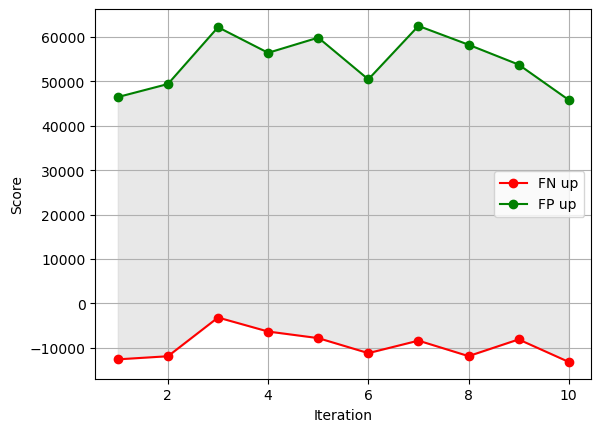

Custom score with increased FN:  [-12616.27, -11916.61, -3194.42, -6350.98, -7833.93, -11214.46, -8400.32, -11888.93, -8129.03, -13197.08]
Custom score with increased FP:  [46472.78, 49411.13, 62207.89, 56439.37, 59859.34, 50457.04, 62497.58, 58263.63, 53787.92, 45826.37]
Average custom score with increased FN:  -9474.203
Average custom score with increased FP:  54522.30500000001


In [463]:
calculate_sensitivity()

In the results of the cross-validation we can see that the model quality based on the custom model evaluation is more sensitive to false positive values than to false negative values. We can see this in the diagram that the FN-score is at average 63184.893 better than the score of the baseline we previously defined.
This means, if we falsely predict that one should by a ticket now, but the price will actually go down, it is worse than if we falsely predict that one should wait, but the price will actually go up. 


To conclude, we have determined that false positives  are more costly than false negatives. Consequently, the F1 score is an appropriate metric, ensuring that we strike a balance between precision and recall while minimizing the cost of false positives. This approach aligns with our objective of providing accurate buy/wait recommendations to potential flight purchasers, with an emphasis on avoiding premature buying decisions that could lead to unnecessary expenses.

TODO: describe

In [464]:
# Create a function to calculate the metrics
def calculate_metrics(y_test, y_pred):
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))
    print('ROC AUC: ', roc_auc_score(y_test, y_pred))

# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Create a function to plot the Learning Curve
def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Create a function to plot the ROC Curve
def plot_roc_curve(estimator, X, y, cv=5):
    # Compute probabilities
    y_pred_prob = estimator.predict_proba(X_test)[:,1]
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.figure()
    lw = 2  # line width
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

#### Scaling ####

In [465]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

#### Custom Score Function ####

In [472]:
from sklearn.metrics import make_scorer


# def custom_metric(y_pred, X):

#     # reset the index of the X DataFrame
#     # X = X.reset_index(drop=True)
    
#     # Create a DataFrame from the predicted values
#     df = pd.DataFrame({'buy': y_pred})

#     # Add the additional columns
#     df['flight_unique_id'] = X['flight_unique_id']
#     df['Request_Date'] = X['Request_Date']
#     df['Price_In_Eur'] = X['Price_In_Eur']

#     # Call the original evaluation function
#     return model_quality_evaluation(df)

def custom_metric(y_pred, X_test, X_test_full):

    test_df = X_test.copy()
    test_df['Request_Date'] = X_test_full.loc[X_test.index, 'Request_Date']
    test_df['flight_unique_id'] = X_test_full.loc[X_test.index, 'flight_unique_id']
    test_df['Price_In_Eur'] = X_test_full.loc[X_test.index, 'Price_In_Eur']
    test_df['buy'] = y_pred

    # Convert the data types to match the custom metric function requirements
    test_df['Request_Date'] = test_df['Request_Date'].dt.dayofyear
    test_df['buy'] = test_df['buy'].astype(bool)
    print(test_df.info())

    # Call the original evaluation function
    return model_quality_evaluation(test_df), test_df

custom_scorer = make_scorer(custom_metric, greater_is_better=True)

#### Random Forest Classifier ####

In [467]:
# Train a Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [348]:
# plot_learning_curve(rfc, X_train, y_train)

In [349]:
# plot_roc_curve(rfc, X_train, y_train)

Accuracy:  0.876831091180867
Precision:  0.8192322027581066
Recall:  0.5825602968460112
F1:  0.6809169764560099
ROC AUC:  0.7725571712766189


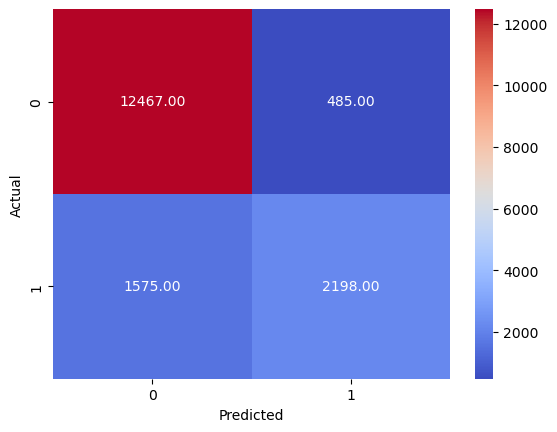

In [350]:
# Make predictions on the test set
predictions = rfc.predict(X_test)
calculate_metrics(y_test, predictions)
plot_confusion_matrix(y_test, predictions)

In [351]:
custom_metric(predictions, X_test_full)

-193443.35

##### Optimize Hyperparameters #####

In [352]:
# optimize the hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [5, 10, 15]
}

###### Custom GridSearchCV ######

In [353]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import itertools

def grid_search_cv(estimator, param_grid, X, y, custom_scorer):    
    # Create an empty dictionary to store the mean accuracy for each parameter combination
    results = {}

    # Get all parameter combinations
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # Loop through each parameter combination
    for i, params in enumerate(param_combinations):
        custom_scores = []
        print(f"Starting cross-validation for parameter combination {i+1} out of {len(param_combinations)}: {params}")

        # Perform cross-validation
        for j in range(5):
            print(f"\tStarting fold {j+1} out of 5")
            # Split the data into training and test sets
            X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            X_train = X_train_full.drop(['flight_unique_id', 'Request_Date'], axis=1)
            X_test = X_test_full.drop(['flight_unique_id', 'Request_Date'], axis=1)

            # Set the parameters and fit the estimator
            estimator.set_params(**params)
            estimator.fit(X_train, y_train)

            # Predict on the test set and calculate the accuracy
            y_pred = estimator.predict(X_test)
            # list to dataframe
            y_pred = pd.DataFrame(y_pred, columns=['buy'])
            accuracy = accuracy_score(y_test, y_pred)
            X_test_full = X_test_full.reset_index(drop=True)
            df_combined = pd.concat([y_pred, X_test_full], axis=1)
            score = model_quality_evaluation(df_combined)

            # Append the accuracy to the accuracy_scores list
            custom_scores.append(score)

        # Calculate the mean accuracy for this parameter combination and store it in the results dictionary
        results[str(params)] = np.mean(custom_scores)

        print(f"Finished cross-validation for parameter combination {i+1} out of {len(param_combinations)}: {params}")
        print(f"Mean score: {results[str(params)]}\n")

    # Get the parameter combination with the highest mean accuracy
    best_params = max(results, key=results.get)
    best_score = results[best_params]

    print(f"Best parameter combination: {best_params}")
    print(f"Best score: {best_score}")

    return best_params, best_score

In [354]:
# best_params, best_score = grid_search_cv(rfc, param_grid, X, y, custom_scorer)

###### RandomizedSearchCV (TODO: entfernen) ######

1. ROC_AUC

1.1 RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rfc = RandomForestClassifier(random_state=42)

randomized_search_roc_auc = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, n_iter=10, cv=5, verbose=1, scoring='roc_auc' , random_state=42)
randomized_search_roc_auc.fit(X_train, y_train)

print(randomized_search_roc_auc.best_params_)
print(randomized_search_roc_auc.best_score_)

best_params_roc_auc = randomized_search_roc_auc.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 20}
0.8651349699448222


1.2 Retrain model

In [ ]:
rfc = RandomForestClassifier(**best_params_roc_auc, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, random_state=42)

Accuracy:  0.8393423019431988
Precision:  0.8023385300668151
Recall:  0.3819241982507289
F1:  0.5175076315316933
ROC AUC:  0.6772576519357413


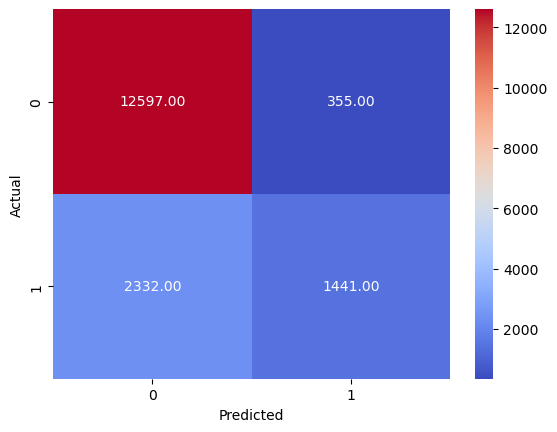

-396333.33

In [ ]:
# plot_learning_curve(rfc, X_train, y_train)
# plot_roc_curve(rfc, X_train, y_train)

# Make predictions on the test set
predictions = rfc.predict(X_test)
calculate_metrics(y_test, predictions)
plot_confusion_matrix(y_test, predictions)
custom_metric(predictions, X_test_full)

2. Accuracy

2.1 RandomizedSearchCV

In [ ]:
rfc = RandomForestClassifier(random_state=42)

randomized_search_accuracy = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, n_iter=10, cv=5, verbose=1, scoring='accuracy' , random_state=42)
randomized_search_accuracy.fit(X_train, y_train)

print(randomized_search_accuracy.best_params_)
print(randomized_search_accuracy.best_score_)

best_params_acc = randomized_search_accuracy.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 20}
0.8379348198786868


2.1 Retrain Model

In [ ]:
rfc = RandomForestClassifier(**best_params_acc, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, random_state=42)

Accuracy:  0.8393423019431988
Precision:  0.8023385300668151
Recall:  0.3819241982507289
F1:  0.5175076315316933
ROC AUC:  0.6772576519357413


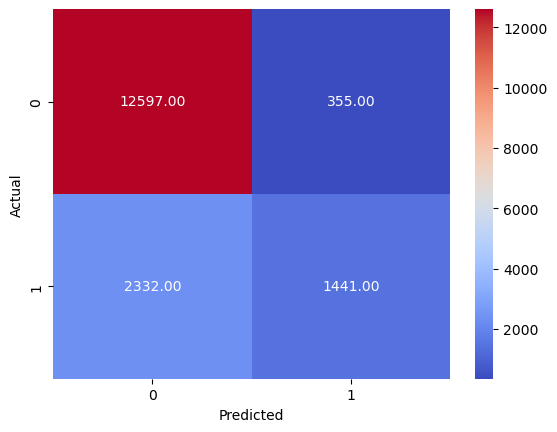

-396333.33

In [ ]:
# plot_learning_curve(rfc, X_train, y_train)
# plot_roc_curve(rfc, X_train, y_train)

# Make predictions on the test set
predictions = rfc.predict(X_test)
calculate_metrics(y_test, predictions)
plot_confusion_matrix(y_test, predictions)
custom_metric(predictions, X_test_full)

3. F1 score

3.1 RandomizedSearchCV

In [ ]:
rfc = RandomForestClassifier(random_state=42)

randomized_search_f1 = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, n_iter=10, cv=5, verbose=1, scoring='f1' , random_state=42)
randomized_search_f1.fit(X_train, y_train)

print(randomized_search_f1.best_params_)
print(randomized_search_f1.best_score_)

best_params_f1 = randomized_search_f1.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 20}
0.5130497767528583


3.1 Retrain Model

In [ ]:
rfc = RandomForestClassifier(**best_params_f1, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, random_state=42)

Accuracy:  0.8393423019431988
Precision:  0.8023385300668151
Recall:  0.3819241982507289
F1:  0.5175076315316933
ROC AUC:  0.6772576519357413


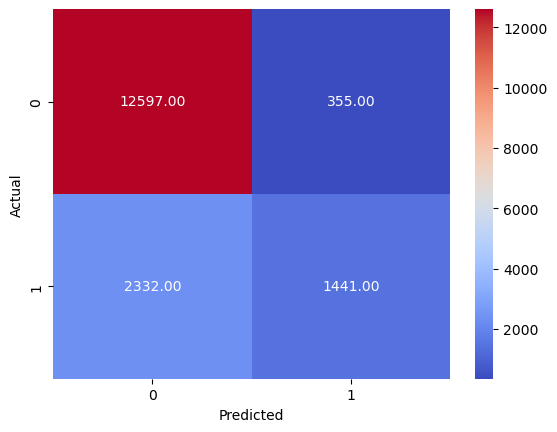

-389190.21

In [ ]:
# plot_learning_curve(rfc, X_train, y_train)
# plot_roc_curve(rfc, X_train, y_train)

# Make predictions on the test set
predictions = rfc.predict(X_test)
calculate_metrics(y_test, predictions)
plot_confusion_matrix(y_test, predictions)
custom_metric(predictions, X_test_full)

4. Precision

4.1 RandomizedSearchCV

In [ ]:
rfc = RandomForestClassifier(random_state=42)

randomized_search_precision = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, n_iter=10, cv=5, verbose=1, scoring='precision' , random_state=42)
randomized_search_precision.fit(X_train, y_train)

print(randomized_search_precision.best_params_)
print(randomized_search_precision.best_score_)

best_params_precision = randomized_search_precision.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 10}
0.8002846086345045


4.2 Retrain Model

In [ ]:
rfc = RandomForestClassifier(**best_params_precision, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, random_state=42)

Accuracy:  0.8199701046337817
Precision:  0.8365724381625441
Recall:  0.25099390405512856
F1:  0.38613659531090727
ROC AUC:  0.618355197858324


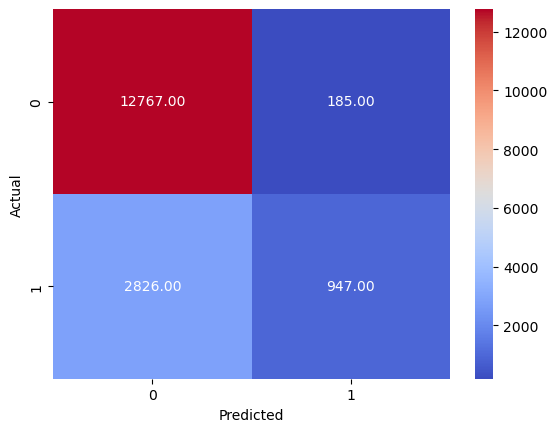

-530228.0

In [ ]:
# plot_learning_curve(rfc, X_train, y_train)
# plot_roc_curve(rfc, X_train, y_train)

# Make predictions on the test set
predictions = rfc.predict(X_test)
calculate_metrics(y_test, predictions)
plot_confusion_matrix(y_test, predictions)
custom_metric(predictions, X_test_full)

#### Logistic Regression ####

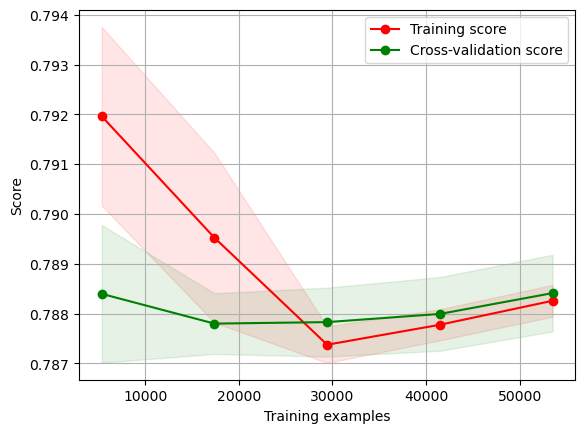

Accuracy:  0.7883974349392368
Precision:  0.7011728709841918
Recall:  0.09200401472064236
F1:  0.1626641429078434
ROC AUC:  0.5403624030950096


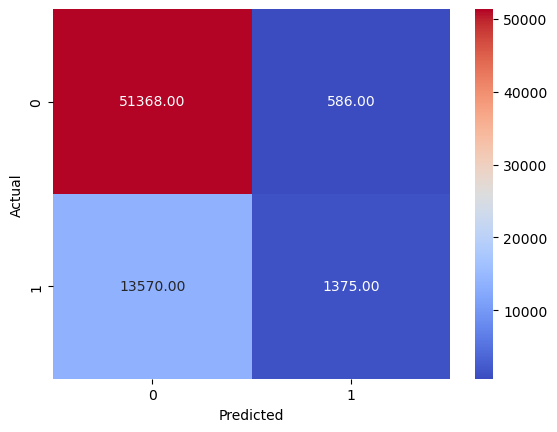

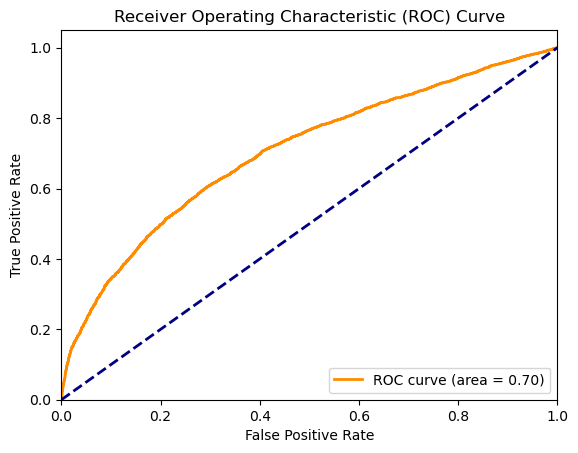

In [ ]:
# Train a Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lr.fit(X_train, y_train)
plot_learning_curve(lr, X_train, y_train)
calculate_metrics(y_train, lr.predict(X_train))
plot_confusion_matrix(y_train, lr.predict(X_train))
plot_roc_curve(lr, X_train, y_train)

In [ ]:
# optimize the hyperparameters
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'C': 10, 'penalty': 'l2'}

#### Gradient Boosting Classifier ####

In [ ]:
import xgboost as xgb


# Train a XGBoost model

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(X_train, y_train)

In [ ]:
plot_learning_curve(xgb_model, X_train, y_train)
plot_roc_curve(xgb_model, X_train, y_train)

Accuracy:  0.864813153961136
Precision:  0.8126550868486352
Recall:  0.5208057248873575
F1:  0.6347924406396382
ROC AUC:  0.7429152157481878


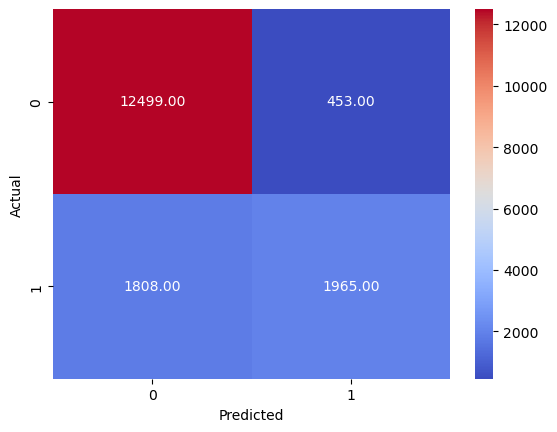

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16725 entries, 8619 to 80048
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Price_In_Eur                     16725 non-null  float64
 1   Flight_Day_of_Week               16725 non-null  int64  
 2   Departure_hour                   16725 non-null  int64  
 3   days_between_request_and_flight  16725 non-null  int64  
 4   route_abb_FRA-STN                16725 non-null  uint8  
 5   route_abb_STN-FRA                16725 non-null  uint8  
 6   route_abb_STN-SXF                16725 non-null  uint8  
 7   route_abb_SXF-STN                16725 non-null  uint8  
 8   price_trend                      16524 non-null  float64
 9   Request_Date                     16725 non-null  int64  
 10  flight_unique_id                 16725 non-null  object 
 11  buy                              16725 non-null  bool   
dtypes: bool(1), flo

In [474]:
# Make predictions on the test set
predictions = xgb_model.predict(X_test)
calculate_metrics(y_test, predictions)
plot_confusion_matrix(y_test, predictions)
score, df = custom_metric(predictions, X_test, X_test_full)

# save df to disk
df.to_csv('test_df.csv', index=False)

In [ ]:
# Optimize the hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': sp_randInt(50, 1000),
    'learning_rate': sp_randFloat(0.01, 1.0),
    'subsample': sp_randFloat(0.1, 1.0),
    'max_depth': sp_randInt(1, 10),
    'min_samples_split': sp_randInt(2, 20),
    'min_samples_leaf': sp_randInt(1, 20),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

random_search_gbc = RandomizedSearchCV(gbc, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=-1)

random_search_gbc.fit(X_train, y_train)

best_params_gbc = random_search_gbc.best_params_

KeyboardInterrupt: 

In [ ]:
gbc = GradientBoostingClassifier(**best_params_gbc, random_state=42)
gbc.fit(X_train, y_train)
# plot_learning_curve(gbc, X_train, y_train)
# calculate_metrics(y_train, gbc.predict(X_train))
plot_confusion_matrix(y_train, gbc.predict(X_train))
plot_roc_curve(gbc, X_train, y_train)

calculate_metrics(gbc.predict(X_test), X_test_full)

#### Support Vector Machine Classifier ####

In [ ]:
# Train a Support Vector Machine Classifier
# from sklearn.svm import SVC

# svc = SVC(random_state=42)
# svc.fit(X_train, y_train)
# plot_learning_curve(svc, X_train, y_train)
# calculate_metrics(y_train, svc.predict(X_train))
# plot_confusion_matrix(y_train, svc.predict(X_train))
# plot_roc_curve(svc, X_train, y_train)

In [ ]:
# optimize the hyperparameters
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'gamma': ['scale', 'auto'],
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
# }

# grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

#### K-Nearest Neighbors Classifier ####

In [ ]:
# Train a K-Nearest Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
plot_learning_curve(knn, X_train, y_train)
calculate_metrics(y_train, knn.predict(X_train))
plot_confusion_matrix(y_train, knn.predict(X_train))
plot_roc_curve(knn, X_train, y_train)

In [ ]:
# optimize the hyperparameters
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(X_train, y_train)
grid_search.best_params_

#### Gaussian Naive Bayes Classifier ####

In [ ]:
# Train a Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
plot_learning_curve(gnb, X_train, y_train)
calculate_metrics(y_train, gnb.predict(X_train))
plot_confusion_matrix(y_train, gnb.predict(X_train))
plot_roc_curve(gnb, X_train, y_train)

In [ ]:
# optimize the hyperparameters
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(X_train, y_train)
grid_search.best_params_

#### MLP Classifier ####

In [ ]:
from sklearn.neural_network import MLPClassifier

# Create a MLPClassifier object
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)

# Train the model
mlp.fit(X_train, y_train)

# Predict the values
y_pred = mlp.predict(X_test)

# Print the accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Plot the confusion matrix
plot_confusion_matrix(mlp, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

#### Model: always predict not buy ####

Accuracy:  0.7744095665171898
Precision:  0.0
Recall:  0.0
F1:  0.0
ROC AUC:  0.5


d:\Programme\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


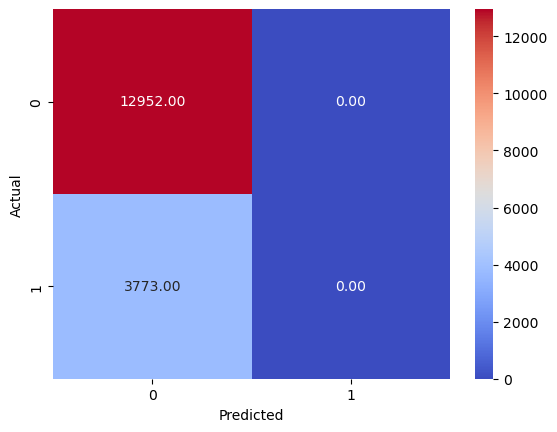

In [ ]:
predictions_not_buy = np.zeros(len(y_test))

calculate_metrics(y_test, predictions_not_buy)
plot_confusion_matrix(y_test, predictions_not_buy)

In [ ]:
custom_metric(predictions_not_buy, X_test_full)

C:\Users\sbene\AppData\Local\Temp\ipykernel_18464\1914952590.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  request_dates.sort_values(by='Request_Date', ascending=False, inplace=True)


-791102.89

### min_future_price_in_Eur as target ###

In [ ]:
# No. 2 Define the features and the target
X = df_train_copy[['Price_In_Eur', 'Flight_Day_Of_Week', 'Departure_hour', 'Request_Date',
    'days_between_request_and_flight', 'is_holiday', 'is_weekend', 'price_trend', 'flight_unique_id']]
y = df_train_copy['min_future_Price_in_Eur']

# Split the data into train and test data
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# remove the flight_unique_id from the train and test data
X_train = X_train_full.drop(['flight_unique_id', 'Request_Date'], axis=1)
X_test = X_test_full.drop(['flight_unique_id', 'Request_Date'], axis=1)

#### Linear Regression ###